# Image Denoising Using Deep Learning Architectures

## 1. Introduction

This report explores the application of deep learning techniques to image denoising tasks. The objective is to evaluate and compare the performance of different neural network architectures—Fully Connected Neural Networks (FCNN), Autoencoders, and U-Nets—on noisy image datasets. Two widely-used datasets, **MNIST** and **CIFAR-10**, are used in the experiments.

## 2. Data Preparation

### 2.1 Dataset Loading

The following datasets were loaded using TensorFlow's dataset utilities:

- **MNIST**: Grayscale handwritten digits dataset.
- **CIFAR-10**: RGB images from 10 object classes.

#### Load the tesorflow datasets

In [ ]:
# Import necessary libraries
import tensorflow as tf

# Load the MNIST dataset
mnist_data = tf.keras.datasets.mnist
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = mnist_data.load_data()

# Load the CIFAR-10 dataset
cifar10_data = tf.keras.datasets.cifar10
(train_images_cifar, train_labels_cifar), (test_images_cifar, test_labels_cifar) = cifar10_data.load_data()

# Display dataset info
print(f'MNIST Training images shape: {train_images_mnist.shape}')
print(f'MNIST Test images shape: {test_images_mnist.shape}')
print(f'CIFAR-10 Training images shape: {train_images_cifar.shape}')
print(f'CIFAR-10 Test images shape: {test_images_cifar.shape}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
MNIST Training images shape: (60000, 28, 28)
MNIST Test images shape: (10000, 28, 28)
CIFAR-10 Training images shape: (50000, 32, 32, 3)
CIFAR-10 Test images shape: (10000, 32, 32, 3)


### 2.2 Noise Addition Functions

To simulate real-world degradation, noise was added using the following methods:

- **Gaussian Noise**
- **Salt-and-Pepper Noise**
- **Combination of Gaussian + Salt-and-Pepper**

In [1]:
import numpy as np

def add_gaussian_noise(image, mean=0, stddev=0.1):
    """Adds Gaussian noise to an image.

    Args:
      image: The input image as a NumPy array.
      mean: The mean of the Gaussian distribution.
      stddev: The standard deviation of the Gaussian distribution.

    Returns:
      The noisy image as a NumPy array.
    """
    image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)  # Clip to ensure pixel values are within [0, 1]
    return noisy_image


def add_salt_and_pepper_noise(image, salt_prob=0.1, pepper_prob=0.1):
    """
    Add salt and pepper noise to an image.

    Parameters:
    -----------
    image: np.ndarray or tf.Tensor
        Input image with values in range [0, 1]
    salt_prob: float
        Probability of adding salt (white) noise
    pepper_prob: float
        Probability of adding pepper (black) noise

    Returns:
    --------
    np.ndarray or tf.Tensor
        Noisy image with values in range [0, 1]
    """
    image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    # NumPy implementation
    noisy_image = np.copy(image)

    # Add salt (white) noise
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 1.0

    # Add pepper (black) noise
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0.0

    return noisy_image

def add_gaussian_sp_noise(image, mean=0, stddev=0.1, salt_prob=0.1, pepper_prob=0.1):
    """Adds Gaussian and salt and pepper noise to an image.

    Parameters:
    -----------
    image: np.ndarray or tf.Tensor
        Input image with values in range [0, 1]
    mean: float
        Mean of the Gaussian distribution
    stddev: float
        Standard deviation of the Gaussian distribution
    salt_prob: float
        Probability of adding salt (white) noise
    pepper_prob: float
        Probability of adding pepper (black) noise

        Returns:
    --------
    np.ndarray or tf.Tensor
        Noisy image with values in range [0, 1]
    """

    # image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]


    noise = np.random.normal(mean, stddev, image.shape)
    # NumPy implementation
    noisy_image = np.copy(image)

    # Add salt (white) noise
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 1.0

    # Add pepper (black) noise
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0.0

    noisy_image = np.clip(noisy_image + noise, 0, 1)  # Clip to ensure pixel values are within [0, 1]

    return noisy_image




These functions normalize the images and apply noise, returning images with values in the [0, 1] range.

### 2.3 Test the noise functions

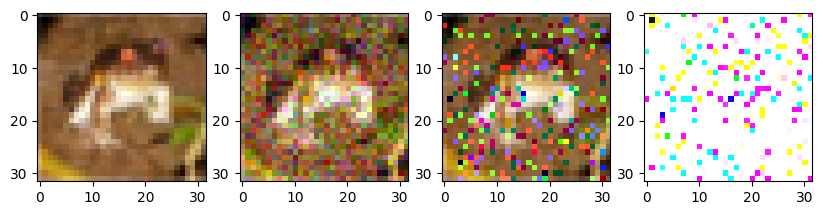

In [ ]:
import matplotlib.pyplot as plt
from skimage.util import random_noise

_, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(train_images_cifar[0], cmap='gray')

image_gaussian = add_gaussian_noise(train_images_cifar[0])
ax[1].imshow(image_gaussian, cmap='gray')

image_salt_and_pepper = add_salt_and_pepper_noise(train_images_cifar[0], 0.05, 0.05)
ax[2].imshow(image_salt_and_pepper, cmap='gray')

image_both = add_gaussian_sp_noise(train_images_cifar[0], pepper_prob=0.05, salt_prob=0.05)
ax[3].imshow(image_both, cmap='gray')

plt.show()

## 3. Model Architectures

Three types of neural network models are proposed for denoising:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 3.1 Fully Connected Neural Network (FCNN)

A simple multi-layer perceptron where images are flattened before input and reshaped back after reconstruction.

In [4]:
class FCNN(nn.Module):
    """
    Fully Connected Neural Network (FCNN) implementation.

    Args:
        input_size (int): Size of the input features.
        hidden_sizes (list): List of hidden layer sizes.
        output_size (int): Size of the output features.
        dropout_rate (float): Dropout probability for regularization.
    """
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_size),
            nn.Sigmoid())

    def forward(self, x):
        """Forward pass through the network."""
        x = self.flatten(x)
        x = self.fc(x)
        return x

### 3.2 Autoencoder

A symmetric neural network consisting of an encoder and decoder designed to compress and reconstruct images.

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2

            # Third convolutional layer (modified)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Added another convolutional layer
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upsample by 2, adjust input channels
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample by 2, adjust input channels
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Adjust to match encoder
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, stride=1, padding=1),  # Adjust output to match input
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 3.3 U-Net

A convolutional neural network architecture with skip connections, commonly used for image-to-image tasks.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling path (encoder)
        self.enc1 = self._conv_block(in_channels, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._conv_block(256, 512)

        # Upsampling path (decoder)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(512, 256)  # 512 due to concatenation

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(256, 128)  # 256 due to concatenation

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)  # 128 due to concatenation

        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()  # For image reconstruction

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                     # 28x28 -> 28x28
        enc2 = self.enc2(self.pool(enc1))       # 28x28 -> 14x14
        enc3 = self.enc3(self.pool(enc2))       # 14x14 -> 7x7

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))  # 7x7 -> 3x3

        # Decoder with skip connections
        dec3 = self.upconv3(bottleneck)         # 3x3 -> 6x6
        # Perform center crop on enc3 to match dec3 size
        if enc3.size()[2:] != dec3.size()[2:]:
            enc3_cropped = self._center_crop(enc3, dec3.size()[2:])
        else:
            enc3_cropped = enc3
        dec3 = self.dec3(torch.cat([dec3, enc3_cropped], dim=1))

        dec2 = self.upconv2(dec3)               # 6x6 -> 12x12
        # Perform center crop on enc2 to match dec2 size
        if enc2.size()[2:] != dec2.size()[2:]:
            enc2_cropped = self._center_crop(enc2, dec2.size()[2:])
        else:
            enc2_cropped = enc2
        dec2 = self.dec2(torch.cat([dec2, enc2_cropped], dim=1))

        dec1 = self.upconv1(dec2)               # 12x12 -> 24x24
        # Perform center crop on enc1 to match dec1 size
        if enc1.size()[2:] != dec1.size()[2:]:
            enc1_cropped = self._center_crop(enc1, dec1.size()[2:])
        else:
            enc1_cropped = enc1
        dec1 = self.dec1(torch.cat([dec1, enc1_cropped], dim=1))

        # Resize output to match input size using interpolation
        if dec1.size()[2:] != x.size()[2:]:
            dec1 = F.interpolate(dec1, size=x.size()[2:], mode='bilinear', align_corners=False)

        return self.final_activation(self.output(dec1))

    def _center_crop(self, tensor, target_size):
        _, _, h, w = tensor.size()
        th, tw = target_size
        i = int(round((h - th) / 2.))
        j = int(round((w - tw) / 2.))
        return tensor[:, :, i:i+th, j:j+tw]

### Example usage

In [6]:
# Test FCNN
fcnn = FCNN(input_size=784)
x = torch.randn(32, 784)  # Batch of 32 flattened MNIST images
output = fcnn(x)
print(f"FCNN output shape: {output.shape}")

FCNN output shape: torch.Size([32, 784])


## 4. Training Pipeline

Each model is trained on the noisy datasets using the following parameters:

- **Loss Functions**: Mean Squared Error (MSE), Structural Similarity Index (SSIM)
- **Optimizers**: Adam or SGD
- **Metrics**: MSE, PSNR, SSIM
- **Other Parameters**: batch size, learning rate, number of epochs

Training involves evaluating the model on a validation set each epoch to monitor performance.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, CIFAR10
!pip install pytorch-msssim
from pytorch_msssim import SSIM

In [ ]:
train_images_cifar_noisy = add_gaussian_sp_noise(train_images_cifar)
train_images_mnist_noisy = add_gaussian_sp_noise(train_images_mnist)
test_images_cifar_noisy = add_gaussian_sp_noise(test_images_cifar)
test_images_mnist_noisy = add_gaussian_sp_noise(test_images_mnist)

In [8]:
def evaluate_denoising_model(model: nn.Module, test_loader, device):
    """
    Evaluate a trained denoising model
    """
    model.eval()
    mse_loss = nn.MSELoss()
    # Get the number of channels from the first batch of data
    num_channels = next(iter(test_loader))[0].shape[1]
    ssim_metric = SSIM(data_range=1.0, size_average=True, channel=num_channels)

    total_mse = 0.0
    total_ssim = 0.0
    num_batches = 0

    with torch.no_grad():
        for data, noisy in test_loader:
            data = data.to(device)
            # Explicitly cast noisy to float32 before sending to device
            noisy = noisy.type(torch.float32).to(device)

            # Forward pass
            denoised_data = model(noisy)

            # Reshape denoised_data to match the shape of data
            denoised_data = denoised_data.view(data.shape)

            # Calculate MSE
            batch_mse = mse_loss(denoised_data, data).item()
            total_mse += batch_mse

            # Calculate SSIM
            batch_ssim = ssim_metric(denoised_data, data).item()
            total_ssim += batch_ssim

            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_ssim = total_ssim / num_batches

    return {
        "MSE": avg_mse,
        "SSIM": avg_ssim,
        "PSNR": 10 * np.log10(1.0 / avg_mse)  # PSNR calculation assuming max pixel value is 1
    }

In [9]:
def train_mnist_denoising(model_type, epochs=10, batch_size=64, learning_rate=0.001, hidden_dims=[256, 128]):
    """
    Train a selected model on the MNIST dataset for denoising
    """
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        # data augmentation
        transforms.RandomRotation(degrees=15)
    ])

    train_ds = MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = MNIST(root='./data', train=False, download=True, transform=transform)

    # Make sure both are proper torch tensors
    train_imgs = train_ds.data.unsqueeze(1).float() / 255.0
    test_imgs = test_ds.data.unsqueeze(1).float() / 255.0

    # Create noisy versions and ensure they're torch tensors
    noisy_train_imgs = add_gaussian_sp_noise(train_imgs, salt_prob=0.01, pepper_prob=0.01) # Reduced noise
    noisy_test_imgs = add_gaussian_sp_noise(test_imgs, salt_prob=0.01, pepper_prob=0.01) # Reduced noise


    # Ensure they're torch tensors with the right type
    if not isinstance(noisy_train_imgs, torch.Tensor):
        noisy_train_imgs = torch.tensor(noisy_train_imgs, dtype=torch.float32)
    if not isinstance(noisy_test_imgs, torch.Tensor):
        noisy_test_imgs = torch.tensor(noisy_test_imgs, dtype=torch.float32)

    # Make sure they have the same shape as the original images
    assert noisy_train_imgs.shape == train_imgs.shape, "Shape mismatch between clean and noisy training images"
    assert noisy_test_imgs.shape == test_imgs.shape, "Shape mismatch between clean and noisy test images"

    # Create datasets with (noisy_image, clean_image) pairs
    train_dataset = TensorDataset(noisy_train_imgs, train_imgs)
    test_dataset = TensorDataset(noisy_test_imgs, test_imgs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    if model_type == 'fcnn':
        model = FCNN(28*28)
    elif model_type == 'autoencoder':
        model = Autoencoder(in_channels=1)
    elif model_type == 'unet':
        model = UNet(in_channels=1, out_channels=1)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Define loss function
    loss_fn = nn.MSELoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Add weight decay

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for noisy, img in train_loader:
            img = img.to(device)
            noisy = noisy.to(device)

            # Forward pass
            if model_type == 'fcnn':
                # Flatten the input for FCNN and Autoencoder
                noisy_flat = noisy.view(noisy.shape[0], -1)
                output = model(noisy_flat)
                output = output.view(img.shape)
            else:
                output = model(noisy)

            # Compute loss
            loss = loss_fn(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for noisy, img in test_loader:
                img = img.to(device)
                noisy = noisy.to(device)

                # Forward pass
                if model_type == 'fcnn':
                    # Flatten the input for FCNN and Autoencoder
                    noisy_flat = noisy.view(noisy.shape[0], -1)
                    output = model(noisy_flat)
                    output = output.view(img.shape)
                else:
                    output = model(noisy)

                # Compute loss
                loss = loss_fn(output, img)

                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Visualize results
    model.eval()
    with torch.no_grad():
        # Get some test data
        noisy_samples, data_samples = next(iter(test_loader))
        noisy_samples = noisy_samples[:8].to(device)
        data_samples = data_samples[:8].to(device)

        # Denoise
        if model_type == 'fcnn':
            # Flatten the input for FCNN and Autoencoder
            noisy_flat = noisy_samples.view(noisy_samples.shape[0], -1)
            denoised_samples = model(noisy_flat)
            denoised_samples = denoised_samples.view(data_samples.shape)
        elif model_type == 'autoencoder':
            # For ConvAutoencoder, use the images directly
            denoised_samples = model(noisy_samples)
        else:
            # For UNet, use the images directly
            denoised_samples = model(noisy_samples)

        # Move tensors to CPU for visualization
        data_samples = data_samples.cpu()
        noisy_samples = noisy_samples.cpu()
        denoised_samples = denoised_samples.cpu()

        # Plot results
        fig, axes = plt.subplots(3, 8, figsize=(16, 6))
        for i in range(8):
            # Original images
            axes[0, i].imshow(data_samples[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Noisy images
            axes[1, i].imshow(noisy_samples[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')

            # Denoised images
            axes[2, i].imshow(denoised_samples[i].squeeze(), cmap='gray')
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Assuming you have an evaluate_denoising_model function
    if 'evaluate_denoising_model' in globals():
        print(evaluate_denoising_model(model, test_loader, device))

    return model, train_losses, val_losses

## 5. Evaluation

Models are evaluated using the following metrics on a held-out test set:

- **Mean Squared Error (MSE)**
- **Peak Signal-to-Noise Ratio (PSNR)**
- **Structural Similarity Index Measure (SSIM)**

### Visual Comparison

Plots and image grids are used to compare:

- Original (clean) images
- Noisy images
- Denoised outputs from each model

### Loss and Metric Curves

Training loss and evaluation metrics are plotted over epochs to visualize convergence and performance trends.


### 5.1 Training and testing the models on the MNIST dataset

Training FCNN on MNIST...


100.0%
100.0%
100.0%
100.0%


Epoch 1/50, Train Loss: 0.0179, Val Loss: 0.0097
Epoch 2/50, Train Loss: 0.0069, Val Loss: 0.0070
Epoch 3/50, Train Loss: 0.0063, Val Loss: 0.0075
Epoch 4/50, Train Loss: 0.0061, Val Loss: 0.0078
Epoch 5/50, Train Loss: 0.0060, Val Loss: 0.0078
Epoch 6/50, Train Loss: 0.0060, Val Loss: 0.0077
Epoch 7/50, Train Loss: 0.0059, Val Loss: 0.0075
Epoch 8/50, Train Loss: 0.0059, Val Loss: 0.0072
Epoch 9/50, Train Loss: 0.0059, Val Loss: 0.0069
Epoch 10/50, Train Loss: 0.0059, Val Loss: 0.0067
Epoch 11/50, Train Loss: 0.0059, Val Loss: 0.0065
Epoch 12/50, Train Loss: 0.0058, Val Loss: 0.0063
Epoch 13/50, Train Loss: 0.0058, Val Loss: 0.0062
Epoch 14/50, Train Loss: 0.0058, Val Loss: 0.0062
Epoch 15/50, Train Loss: 0.0058, Val Loss: 0.0061
Epoch 16/50, Train Loss: 0.0058, Val Loss: 0.0061
Epoch 17/50, Train Loss: 0.0057, Val Loss: 0.0060
Epoch 18/50, Train Loss: 0.0057, Val Loss: 0.0060
Epoch 19/50, Train Loss: 0.0057, Val Loss: 0.0060
Epoch 20/50, Train Loss: 0.0057, Val Loss: 0.0060
Epoch 21/

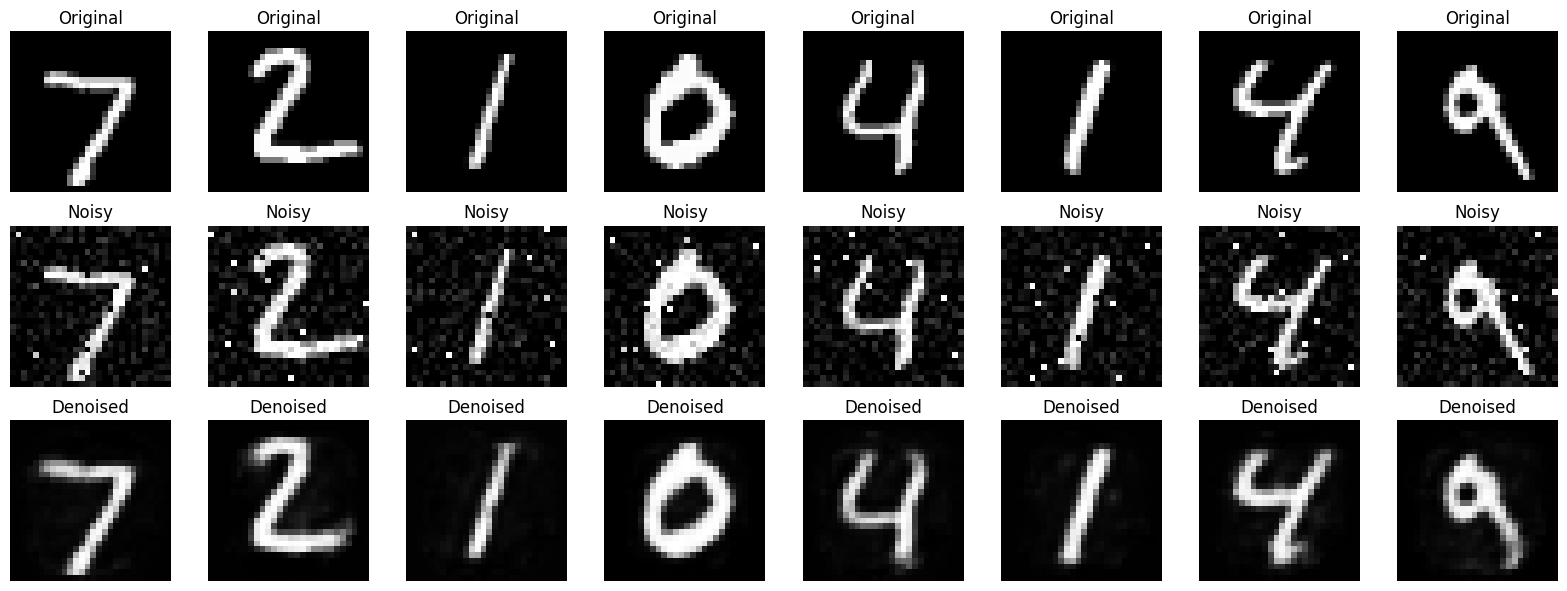

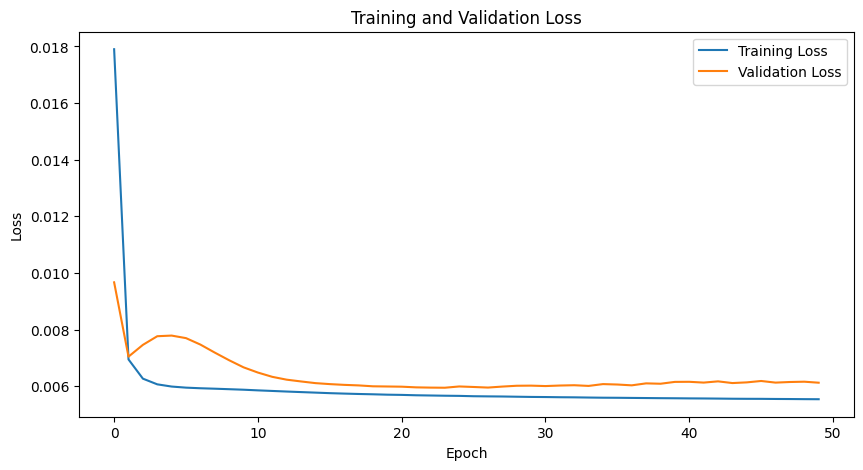

{'MSE': 0.020078756674459786, 'SSIM': 0.7567107639494975, 'PSNR': 16.972631832670128}


In [10]:
# Train MNIST
print("Training FCNN on MNIST...")
fcnn_model, fcnn_train_losses, fcnn_val_losses = train_mnist_denoising("fcnn", epochs=50)

#### 5.1.1 FCNN on MNIST

Using the FCNN model on MNIST gives a satisfying result with a loss lowering quickly.

Training Autoencoder on MNIST...
Epoch 1/50, Train Loss: 0.1126, Val Loss: 0.1141
Epoch 2/50, Train Loss: 0.1120, Val Loss: 0.1141
Epoch 3/50, Train Loss: 0.1120, Val Loss: 0.1141
Epoch 4/50, Train Loss: 0.1120, Val Loss: 0.1141
Epoch 5/50, Train Loss: 0.1120, Val Loss: 0.1141
Epoch 6/50, Train Loss: 0.1120, Val Loss: 0.1141
Epoch 7/50, Train Loss: 0.1103, Val Loss: 0.0978
Epoch 8/50, Train Loss: 0.0194, Val Loss: 0.0107
Epoch 9/50, Train Loss: 0.0080, Val Loss: 0.0077
Epoch 10/50, Train Loss: 0.0068, Val Loss: 0.0066
Epoch 11/50, Train Loss: 0.0060, Val Loss: 0.0064
Epoch 12/50, Train Loss: 0.0055, Val Loss: 0.0060
Epoch 13/50, Train Loss: 0.0051, Val Loss: 0.0056
Epoch 14/50, Train Loss: 0.0048, Val Loss: 0.0053
Epoch 15/50, Train Loss: 0.0045, Val Loss: 0.0048
Epoch 16/50, Train Loss: 0.0043, Val Loss: 0.0046
Epoch 17/50, Train Loss: 0.0042, Val Loss: 0.0046
Epoch 18/50, Train Loss: 0.0041, Val Loss: 0.0042
Epoch 19/50, Train Loss: 0.0040, Val Loss: 0.0046
Epoch 20/50, Train Loss: 0

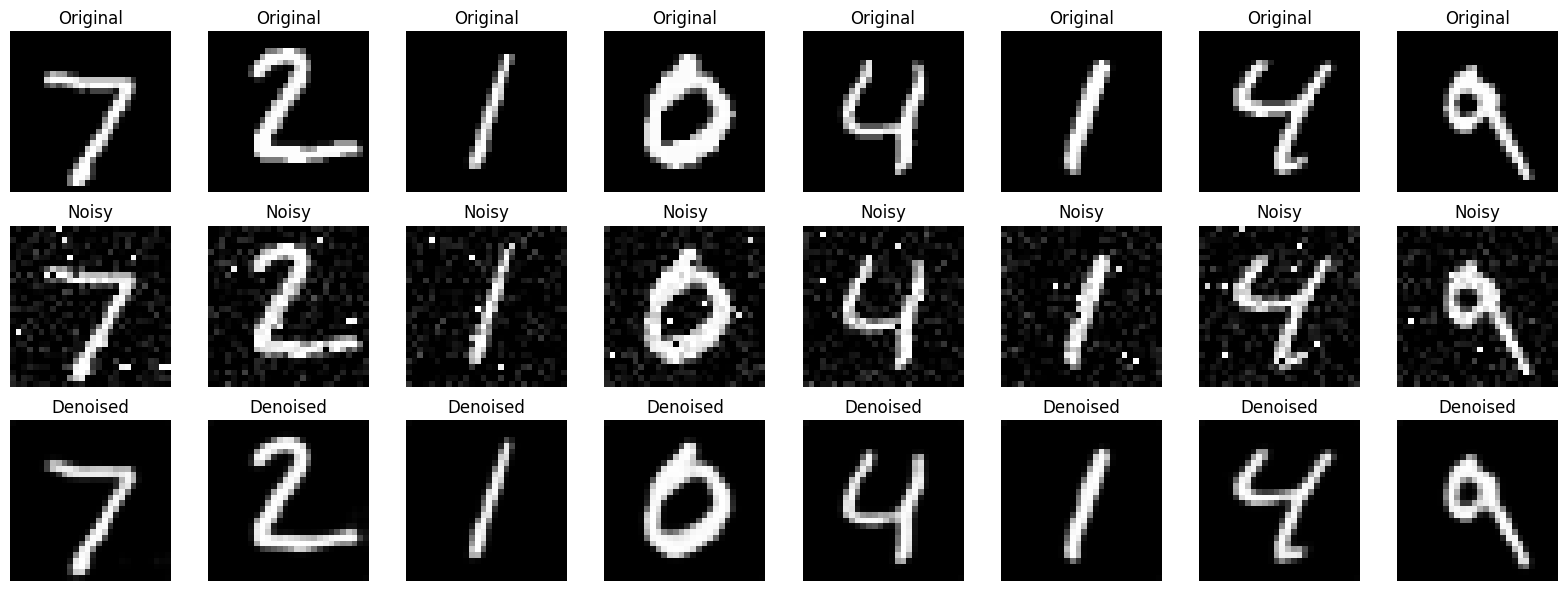

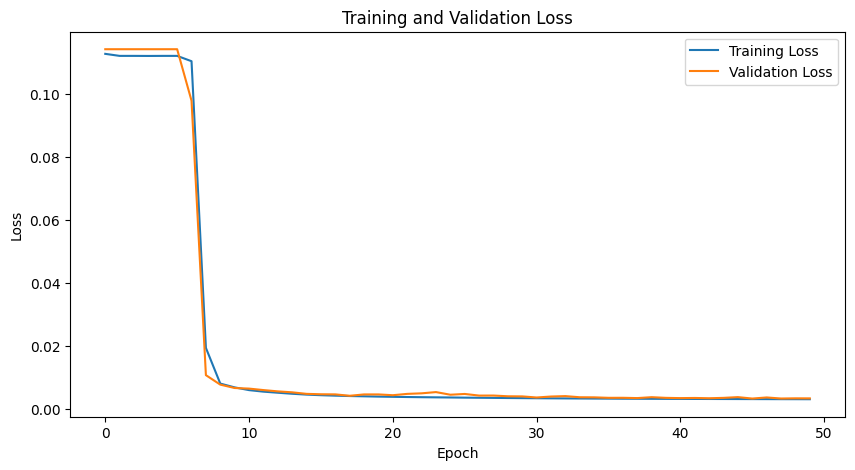

{'MSE': 0.016321887564697084, 'SSIM': 0.7142046777306089, 'PSNR': np.float64(17.87229618160017)}


In [ ]:
# Autoencoder with Mnist
print("Training Autoencoder on MNIST...")
autoencoder_model, autoencoder_train_losses, autoencoder_val_losses = train_mnist_denoising("autoencoder", epochs=50)

#### 5.1.2 Autoencoder on MNIST

Using the Autoencoder on MNIST gives a better result than with the FCNN. However, if the number of epochs is too low the loss stay high and the denoising only returns a black image.

Training Unet on MNIST...
Epoch 1/5, Train Loss: 0.0071, Val Loss: 0.0033
Epoch 2/5, Train Loss: 0.0021, Val Loss: 0.0027
Epoch 3/5, Train Loss: 0.0019, Val Loss: 0.0040
Epoch 4/5, Train Loss: 0.0017, Val Loss: 0.0022
Epoch 5/5, Train Loss: 0.0016, Val Loss: 0.0020


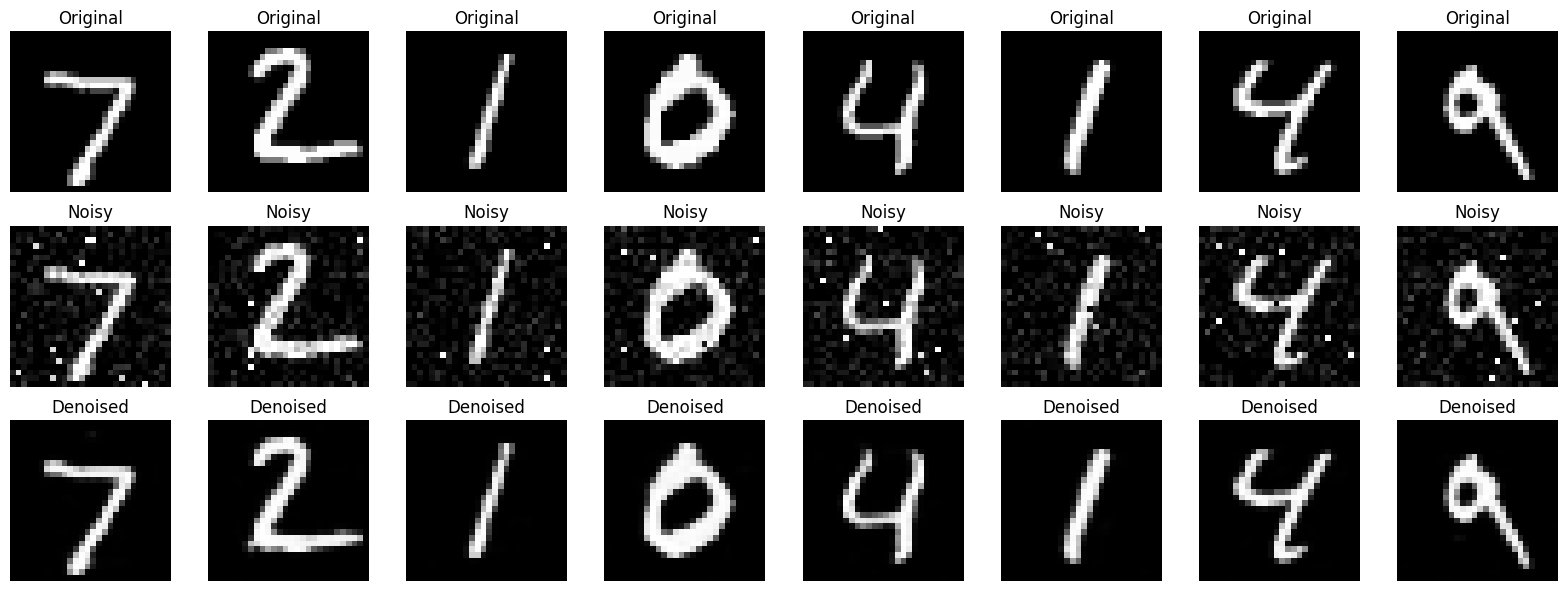

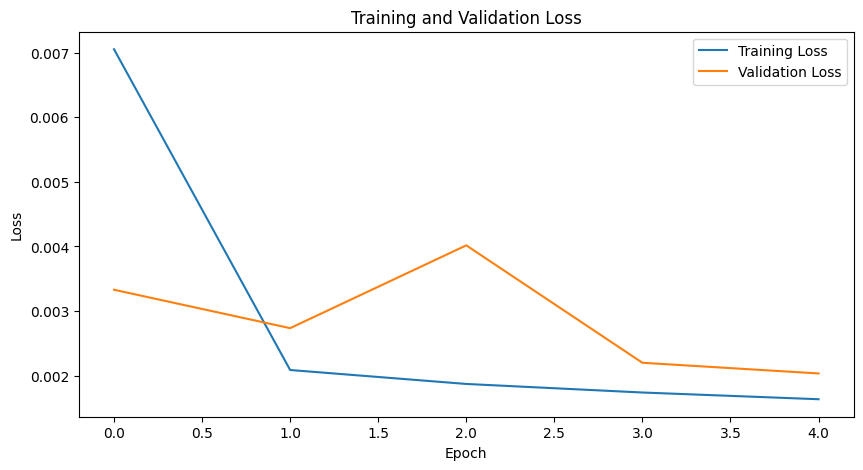

{'MSE': 0.01495407496810339, 'SSIM': 0.7399518345571627, 'PSNR': np.float64(18.25240446469063)}


In [ ]:
# Unet with MNIST
print("Training Unet on MNIST...")
unet_model, unet_train_losses, unet_val_losses = train_mnist_denoising("unet", epochs=5)

#### 5.1.3 Unet on MNIST

Using the Unet on MNIST gives an even better result than with the Autoencoder. However, the training is very slow but with only 5 epochs the results are even better than with 50 epochs on FCNN.

### 5.2 Training and testing the models on the CIFAR dataset

In [ ]:
def train_cifar_denoising(model_type, epochs=10, batch_size=64, learning_rate=0.001, hidden_dims=[256, 128]):
    """
    Train a selected model on the CIFAR10 dataset for denoising
    """
    # Load CIFAR10 dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_ds = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # CIFAR10 is already in (N, H, W, C) format, need to transpose to (N, C, H, W)
    train_imgs = torch.from_numpy(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
    test_imgs = torch.from_numpy(test_ds.data).permute(0, 3, 1, 2).float() / 255.0

    # Generate noisy versions
    noisy_train_imgs = add_gaussian_sp_noise(train_imgs)
    noisy_test_imgs = add_gaussian_sp_noise(test_imgs)

    # Ensure they're proper torch tensors
    if not isinstance(noisy_train_imgs, torch.Tensor):
        noisy_train_imgs = torch.tensor(noisy_train_imgs, dtype=torch.float32)
    if not isinstance(noisy_test_imgs, torch.Tensor):
        noisy_test_imgs = torch.tensor(noisy_test_imgs, dtype=torch.float32)

    # Create datasets with (noisy_image, clean_image) pairs
    train_dataset = TensorDataset(noisy_train_imgs, train_imgs)
    test_dataset = TensorDataset(noisy_test_imgs, test_imgs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    if model_type == 'fcnn':
        model = FCNN(32*32*3)
    elif model_type == 'autoencoder':
        model = Autoencoder(3)
    elif model_type == 'unet':
        model = UNet(in_channels=3, out_channels=3)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Define loss function
    loss_fn = nn.MSELoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Add weight decay

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for noisy, img in train_loader:
            img = img.to(device)
            noisy = noisy.to(device)

            # Forward pass
            if model_type in ['fcnn']:
                # Flatten the input for FCNN and Autoencoder
                noisy_flat = noisy.view(noisy.shape[0], -1)
                output = model(noisy_flat)
                output = output.view(img.shape)
            else:
                # For UNet, use the images directly
                output = model(noisy)

            # Compute loss
            loss = loss_fn(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for noisy, img in test_loader:
                img = img.to(device)
                noisy = noisy.to(device)

                # Forward pass
                if model_type in ['fcnn']:
                    # Flatten the input for FCNN and Autoencoder
                    noisy_flat = noisy.view(noisy.shape[0], -1)
                    output = model(noisy_flat)
                    output = output.view(img.shape)
                else:
                    # For UNet, use the images directly
                    output = model(noisy)

                # Compute loss
                loss = loss_fn(output, img)

                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Visualize results
    model.eval()
    with torch.no_grad():
        # Get some test data
        noisy_samples, data_samples = next(iter(test_loader))
        noisy_samples = noisy_samples[:8].to(device)
        data_samples = data_samples[:8].to(device)

        # Denoise
        if model_type in ['fcnn']:
            # Flatten the input for FCNN and Autoencoder
            noisy_flat = noisy_samples.view(noisy_samples.shape[0], -1)
            denoised_samples = model(noisy_flat)
            denoised_samples = denoised_samples.view(data_samples.shape)
        else:
            # For UNet, use the images directly
            denoised_samples = model(noisy_samples)

        # Move tensors to CPU for visualization
        data_samples = data_samples.cpu()
        noisy_samples = noisy_samples.cpu()
        denoised_samples = denoised_samples.cpu()

        # Plot results
        fig, axes = plt.subplots(3, 8, figsize=(16, 6))
        for i in range(8):
            # Original images (convert from CHW to HWC for display)
            axes[0, i].imshow(data_samples[i].permute(1, 2, 0))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Noisy images (convert from CHW to HWC for display)
            axes[1, i].imshow(noisy_samples[i].permute(1, 2, 0))
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')

            # Denoised images (convert from CHW to HWC for display)
            axes[2, i].imshow(denoised_samples[i].permute(1, 2, 0))
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return model, train_losses, val_losses

In [ ]:
# Train CIFAR
print("Training FCNN on CIFAR...")
fcnn_model_cifar, fcnn_train_losses_cifar, fcnn_val_losses_cifar = train_cifar_denoising("fcnn", epochs=50)

Training FCNN on CIFAR...


KeyboardInterrupt: 

#### 5.2.1 FCNN on CIFAR

TODO

Training Autoencoder on CIFAR...
Epoch 1/5, Train Loss: 0.0140, Val Loss: 0.0083
Epoch 2/5, Train Loss: 0.0079, Val Loss: 0.0074
Epoch 3/5, Train Loss: 0.0071, Val Loss: 0.0067
Epoch 4/5, Train Loss: 0.0064, Val Loss: 0.0062
Epoch 5/5, Train Loss: 0.0061, Val Loss: 0.0060


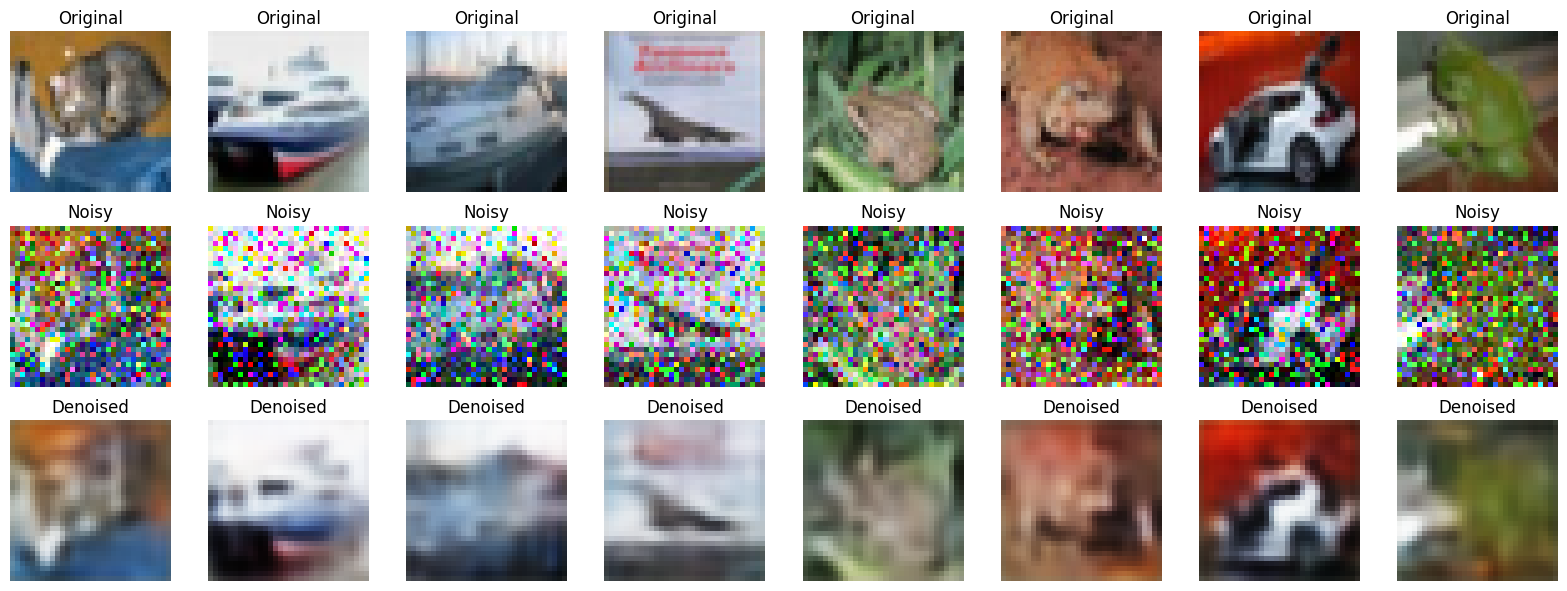

In [ ]:
# Autoencoder with cifar
print("Training Autoencoder on CIFAR...")
autoencoder_model_cifar, autoencoder_train_losses_cifar, autoencoder_val_losses_cifar = train_cifar_denoising("autoencoder", epochs=5)

Training Unet on CIFAR...
Epoch 1/5, Train Loss: 0.0047, Val Loss: 0.0043
Epoch 2/5, Train Loss: 0.0029, Val Loss: 0.0039
Epoch 3/5, Train Loss: 0.0026, Val Loss: 0.0036
Epoch 4/5, Train Loss: 0.0025, Val Loss: 0.0031
Epoch 5/5, Train Loss: 0.0023, Val Loss: 0.0027


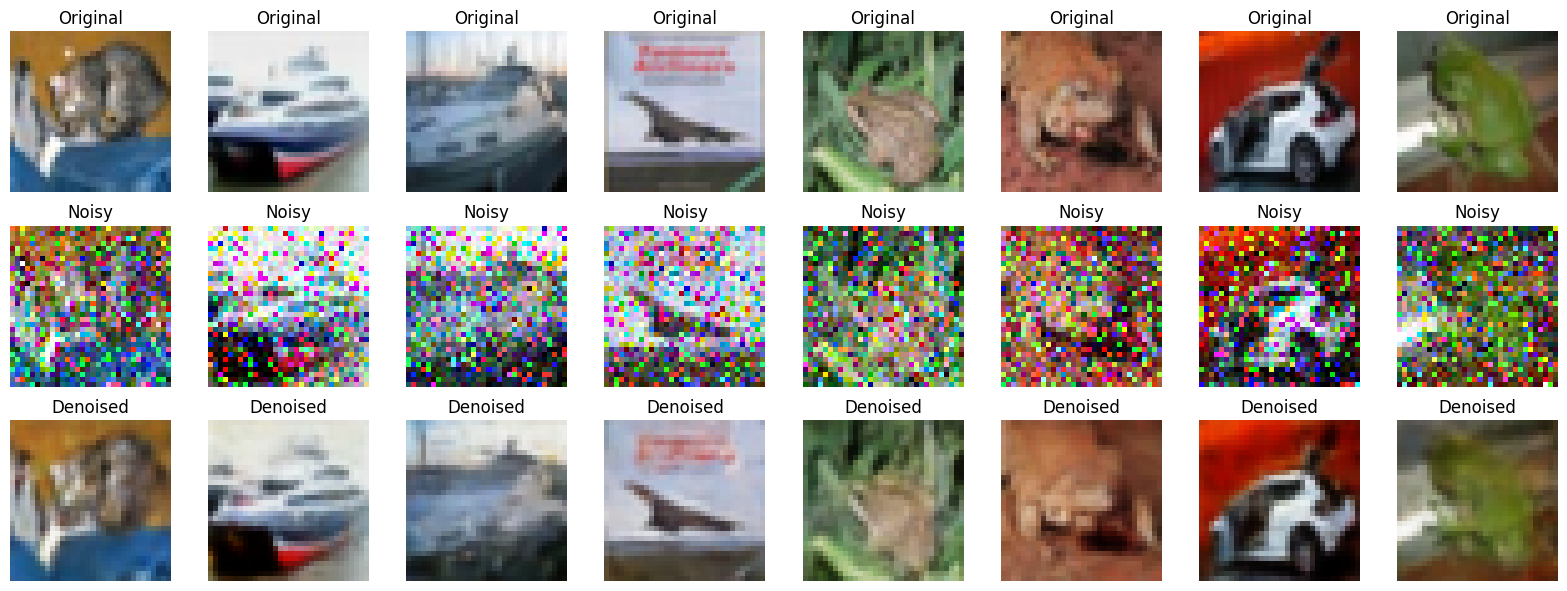

In [ ]:
# Unet with cifar
print("Training Unet on CIFAR...")
unet_model_cifar, unet_train_losses_cifar, unet_val_losses_cifar = train_cifar_denoising("unet", epochs=5)

### 5.3 Training the models on the COCO dataset

### Download the coco dataset



In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip
!unzip train2014.zip
!unzip val2014.zip
!unzip test2014.zip
!rm train2014.zip
!rm val2014.zip
!rm test2014.zip

--2025-03-21 08:47:26--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.139.185, 54.231.131.249, 3.5.28.98, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.139.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip        31%[=====>              ]   4.01G  15.8MB/s    eta 10m 43s^C
--2025-03-21 08:52:27--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.62.49, 3.5.25.159, 52.217.169.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.62.49|:80... connected.
HTTP request sent, awaiting response... ^C
--2025-03-21 08:52:28--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.62.49, 3.5.25.159, 52.217.169.89, ...
Connecting to images.cocodata

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

--2025-03-19 15:02:20--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.11.108, 3.5.30.64, 52.217.123.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.11.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  16.8MB/s    in 16s     

2025-03-19 15:02:36 (15.2 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


## Load COCO

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class COCODataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a common size
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create datasets
train_ds = COCODataset(root_dir='train2014', transform=transform)
test_ds = COCODataset(root_dir='test2014', transform=transform)

In [ ]:
def train_coco_denoising(model_type, epochs=10, batch_size=64, learning_rate=0.001, hidden_dims=[256, 128], fraction=0.1):
    """
    Train a selected model on the COCO dataset for denoising
    """
    import torchvision.transforms as transforms
    from torch.utils.data import DataLoader, TensorDataset
    import torch
    import torch.optim as optim
    import torch.nn as nn
    import numpy as np

    # Get a subset of images
    num_train_samples = int(len(train_ds) * fraction)
    num_test_samples = int(len(test_ds) * fraction)

    train_imgs = [train_ds[i] for i in range(num_train_samples)]
    test_imgs = [test_ds[i] for i in range(num_test_samples)]

    noisy_train_imgs = [add_gaussian_sp_noise(img.permute(1, 2, 0).numpy()) for img in train_imgs] # Apply noise to each image
    noisy_test_imgs = [add_gaussian_sp_noise(img.permute(1, 2, 0).numpy()) for img in test_imgs] # Apply noise to each image

    # Convert noisy images to tensors #
    noisy_train_imgs = torch.stack([torch.from_numpy(img.astype(np.float32)).permute(2, 0, 1) for img in noisy_train_imgs])
    noisy_test_imgs = torch.stack([torch.from_numpy(img.astype(np.float32)).permute(2, 0, 1) for img in noisy_test_imgs])

    # train_imgs and test_imgs are already tensors, convert them to the correct type
    train_imgs = torch.stack(train_imgs).type(torch.float32)
    test_imgs = torch.stack(test_imgs).type(torch.float32)

    # Create datasets with (noisy_image, clean_image) pairs
    train_dataset = TensorDataset(noisy_train_imgs, train_imgs)
    test_dataset = TensorDataset(noisy_test_imgs, test_imgs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
 # Initialize model
    if model_type == 'fcnn':
        model = FCNN(128*128*3)
    elif model_type == 'autoencoder':
        model = Autoencoder(3)
    elif model_type == 'unet':
        model = UNet(in_channels=3, out_channels=3)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Define loss function
    loss_fn = nn.MSELoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Add weight decay

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for noisy, img in train_loader:
            img = img.to(device)
            noisy = noisy.to(device)

            # Forward pass
            if model_type in ['fcnn']:
                # Flatten the input for FCNN and Autoencoder
                noisy_flat = noisy.view(noisy.shape[0], -1)
                output = model(noisy_flat)
                output = output.view(img.shape)
            else:
                # For UNet, use the images directly
                output = model(noisy)

            # Compute loss
            loss = loss_fn(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for noisy, img in test_loader:
                img = img.to(device)
                noisy = noisy.to(device)

                # Forward pass
                if model_type in ['fcnn']:
                    # Flatten the input for FCNN and Autoencoder
                    noisy_flat = noisy.view(noisy.shape[0], -1)
                    output = model(noisy_flat)
                    output = output.view(img.shape)
                else:
                    # For UNet, use the images directly
                    output = model(noisy)

                # Compute loss
                loss = loss_fn(output, img)

                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Visualize results
    model.eval()
    with torch.no_grad():
        # Get some test data
        noisy_samples, data_samples = next(iter(test_loader))
        noisy_samples = noisy_samples[:8].to(device)
        data_samples = data_samples[:8].to(device)

        # Denoise
        if model_type in ['fcnn']:
            # Flatten the input for FCNN and Autoencoder
            noisy_flat = noisy_samples.view(noisy_samples.shape[0], -1)
            denoised_samples = model(noisy_flat)
            denoised_samples = denoised_samples.view(data_samples.shape)
        else:
            # For UNet, use the images directly
            denoised_samples = model(noisy_samples)

        # Move tensors to CPU for visualization
        data_samples = data_samples.cpu()
        noisy_samples = noisy_samples.cpu()
        denoised_samples = denoised_samples.cpu()

        # Plot results
        fig, axes = plt.subplots(3, 8, figsize=(16, 6))
        for i in range(8):
            # Original images (convert from CHW to HWC for display)
            axes[0, i].imshow(data_samples[i].permute(1, 2, 0))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Noisy images (convert from CHW to HWC for display)
            axes[1, i].imshow(noisy_samples[i].permute(1, 2, 0))
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')

            # Denoised images (convert from CHW to HWC for display)
            axes[2, i].imshow(denoised_samples[i].permute(1, 2, 0))
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return model, train_losses, val_losses

Training FCNN on COCO...
Epoch 1/50, Train Loss: 0.0708, Val Loss: 0.0529
Epoch 2/50, Train Loss: 0.0492, Val Loss: 0.0461
Epoch 3/50, Train Loss: 0.0442, Val Loss: 0.0446
Epoch 4/50, Train Loss: 0.0419, Val Loss: 0.0445
Epoch 5/50, Train Loss: 0.0386, Val Loss: 0.0428
Epoch 6/50, Train Loss: 0.0365, Val Loss: 0.0423
Epoch 7/50, Train Loss: 0.0371, Val Loss: 0.0461
Epoch 8/50, Train Loss: 0.0358, Val Loss: 0.0511
Epoch 9/50, Train Loss: 0.0361, Val Loss: 0.0554
Epoch 10/50, Train Loss: 0.0377, Val Loss: 0.0541
Epoch 11/50, Train Loss: 0.0370, Val Loss: 0.0634
Epoch 12/50, Train Loss: 0.0340, Val Loss: 0.0822
Epoch 13/50, Train Loss: 0.0348, Val Loss: 0.0566
Epoch 14/50, Train Loss: 0.0343, Val Loss: 0.0417
Epoch 15/50, Train Loss: 0.0344, Val Loss: 0.0452
Epoch 16/50, Train Loss: 0.0329, Val Loss: 0.0444
Epoch 17/50, Train Loss: 0.0356, Val Loss: 0.0426
Epoch 18/50, Train Loss: 0.0364, Val Loss: 0.0424
Epoch 19/50, Train Loss: 0.0332, Val Loss: 0.0418
Epoch 20/50, Train Loss: 0.0328, V

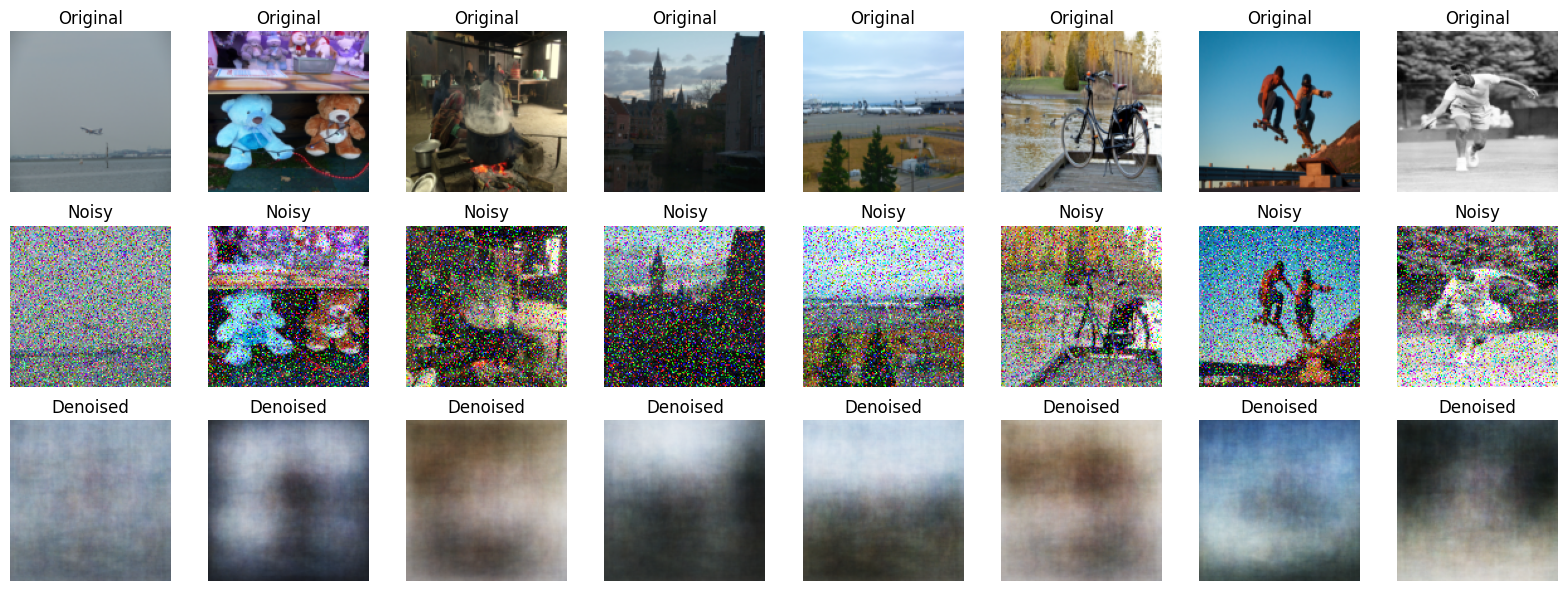

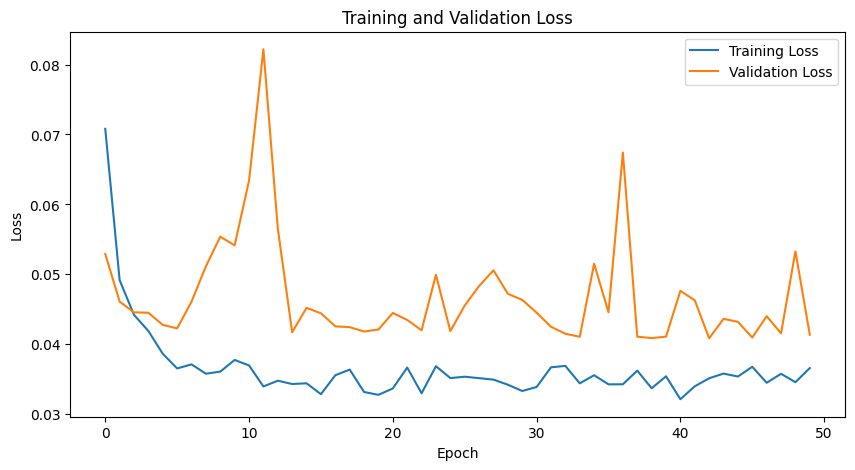

In [ ]:
# FCNN with coco
print("Training FCNN on COCO...")
fcnn_model_coco, fcnn_train_losses_coco, fcnn_val_losses_coco = train_coco_denoising("fcnn", epochs=50, fraction=0.05)

#### 5.3.1 FCNN on COCO

Using the FCNN model on the COCO dataset gives results that are low on loss, but, the images are very blurry. Increasing the number of epochs would not improve the results as seen on the plot.

Training Autoencoder on COCO...
Epoch 1/50, Train Loss: 0.0358, Val Loss: 0.0165
Epoch 2/50, Train Loss: 0.0148, Val Loss: 0.0173
Epoch 3/50, Train Loss: 0.0115, Val Loss: 0.0113
Epoch 4/50, Train Loss: 0.0090, Val Loss: 0.0125
Epoch 5/50, Train Loss: 0.0083, Val Loss: 0.0075
Epoch 6/50, Train Loss: 0.0075, Val Loss: 0.0075
Epoch 7/50, Train Loss: 0.0073, Val Loss: 0.0076
Epoch 8/50, Train Loss: 0.0071, Val Loss: 0.0066
Epoch 9/50, Train Loss: 0.0067, Val Loss: 0.0064
Epoch 10/50, Train Loss: 0.0064, Val Loss: 0.0061
Epoch 11/50, Train Loss: 0.0063, Val Loss: 0.0060
Epoch 12/50, Train Loss: 0.0061, Val Loss: 0.0059
Epoch 13/50, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 14/50, Train Loss: 0.0058, Val Loss: 0.0056
Epoch 15/50, Train Loss: 0.0057, Val Loss: 0.0056
Epoch 16/50, Train Loss: 0.0056, Val Loss: 0.0054
Epoch 17/50, Train Loss: 0.0060, Val Loss: 0.0054
Epoch 18/50, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 19/50, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 20/50, Train Loss: 0.

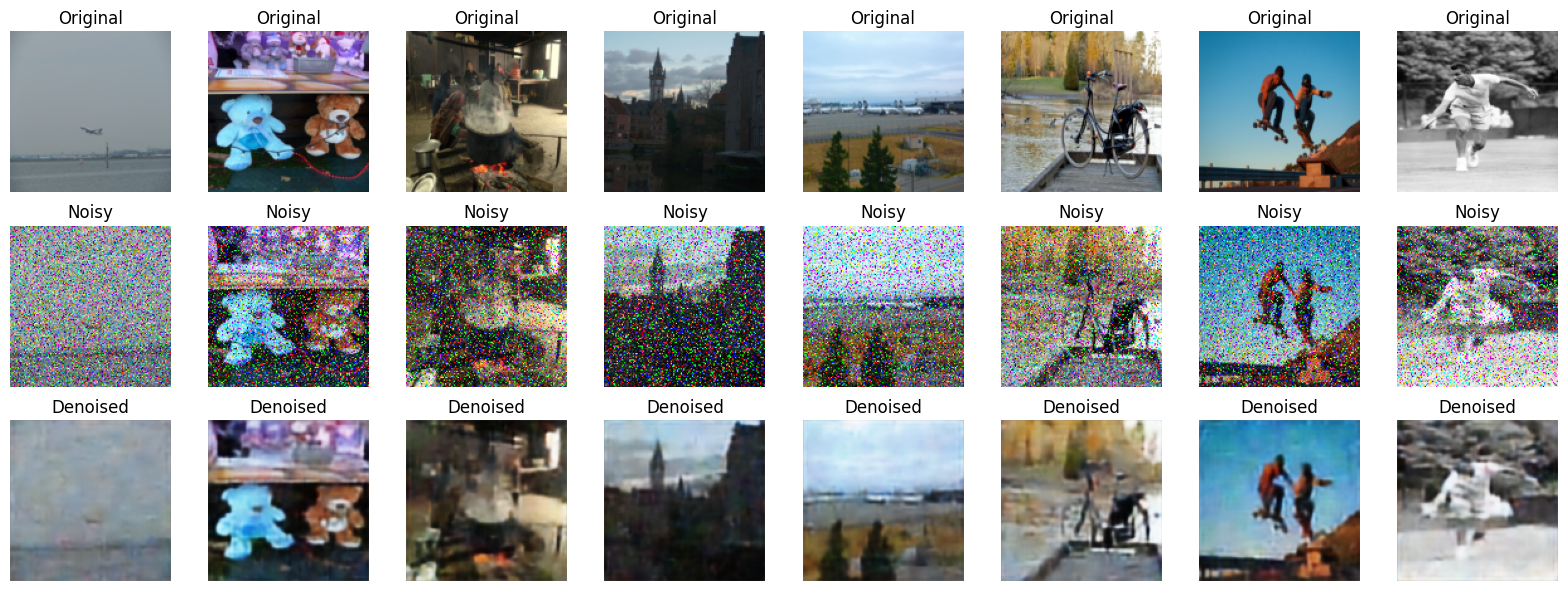

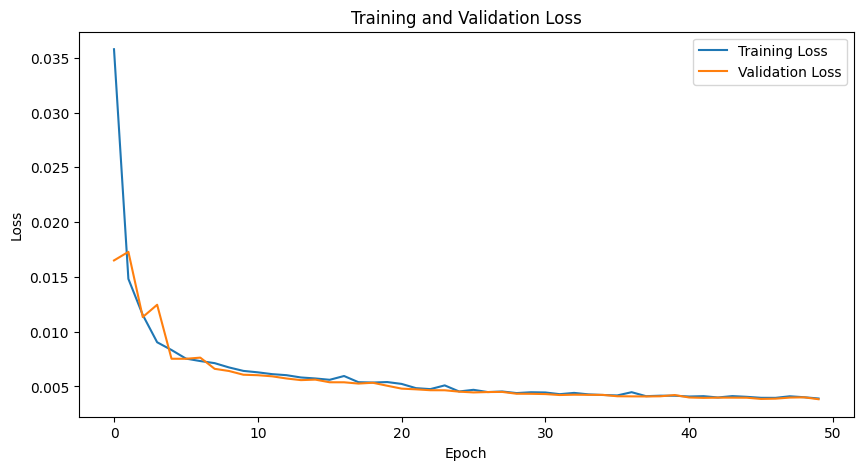

In [ ]:
# Autoencoder with coco
print("Training Autoencoder on COCO...")
autoencoder_model_coco, autoencoder_train_losses_coco, autoencoder_val_losses_coco = train_coco_denoising("autoencoder", epochs=50, fraction=0.05)

#### 5.3.2 Autoencoder on COCO

Using the Autoencoder model on the COCO dataset gives better results than with the FCNN model. The returned images are still pixelated but the they are close enough to the originals.


Training Unet on COCO...
Epoch 1/50, Train Loss: 0.0085, Val Loss: 0.0049
Epoch 2/50, Train Loss: 0.0044, Val Loss: 0.0043
Epoch 3/50, Train Loss: 0.0039, Val Loss: 0.0041
Epoch 4/50, Train Loss: 0.0037, Val Loss: 0.0039
Epoch 5/50, Train Loss: 0.0035, Val Loss: 0.0038
Epoch 6/50, Train Loss: 0.0034, Val Loss: 0.0038
Epoch 7/50, Train Loss: 0.0032, Val Loss: 0.0032
Epoch 8/50, Train Loss: 0.0030, Val Loss: 0.0032
Epoch 9/50, Train Loss: 0.0028, Val Loss: 0.0028
Epoch 10/50, Train Loss: 0.0027, Val Loss: 0.0024
Epoch 11/50, Train Loss: 0.0026, Val Loss: 0.0024
Epoch 12/50, Train Loss: 0.0025, Val Loss: 0.0023
Epoch 13/50, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 14/50, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 15/50, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 16/50, Train Loss: 0.0023, Val Loss: 0.0021
Epoch 17/50, Train Loss: 0.0023, Val Loss: 0.0021
Epoch 18/50, Train Loss: 0.0023, Val Loss: 0.0020
Epoch 19/50, Train Loss: 0.0022, Val Loss: 0.0020
Epoch 20/50, Train Loss: 0.0022, V

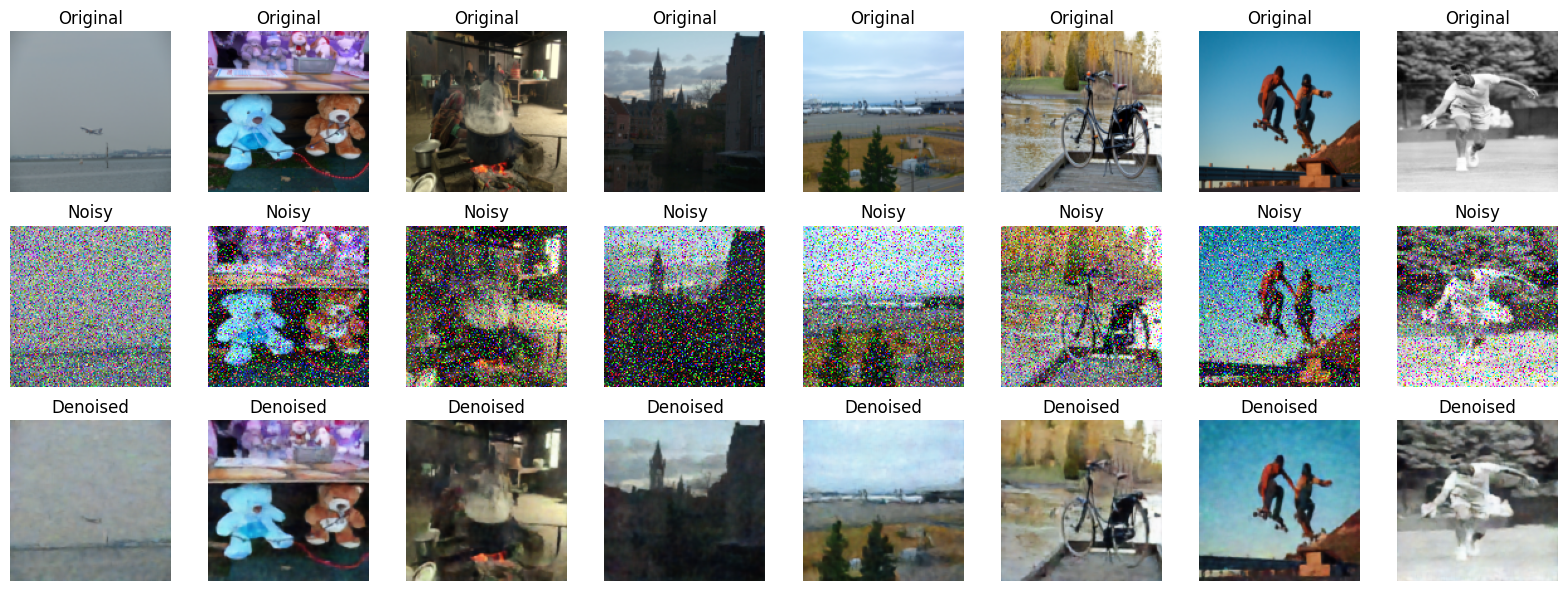

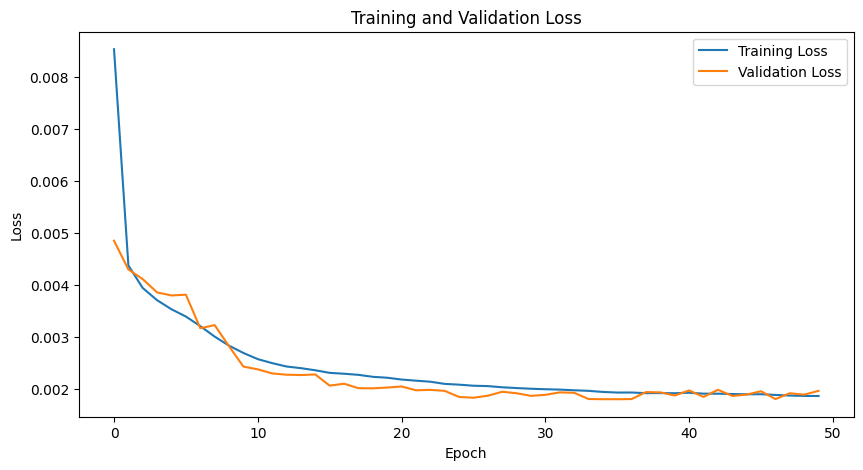

In [ ]:
# Unet with coco
print("Training Unet on COCO...")
unet_model_coco, unet_train_losses_coco, unet_val_losses_coco = train_coco_denoising("unet", epochs=50, fraction=0.05)

#### 5.3.2 Unet on COCO

Using the Unet model on the COCO dataset gives better results than with the Autoencoder model. The returned images have better definitions than the ones denoised by the Autoencoder model.


## 6. Conclusion

This project demonstrates the effectiveness of deep learning models in the context of image denoising. The U-Net architecture is expected to outperform others due to its spatial preservation and skip connections, especially for structured noise patterns.

Further improvements may include:
- Hyperparameter tuning
- Using more diverse datasets
- Exploring GANs for image restoration

# Deep Learning for Semantic Segmentation and Object Detection

## Part I: Semantic Segmentation

### 1 Introduction to Semantic Segmentation

Semantic segmentation assigns a class label to each pixel in an image. You will explore a deep learning model for semantic segmentation: U-Net. The goal is to accurately label each pixel, thereby partitioning the image into semantically meaningful regions. Common evaluation metrics include Intersection over Union (IoU) and Pixel Accuracy.

### 2 Datasets

For semantic segmentation, you may use a subset of the COCO dataset or any publicly available dataset that provides pixel-level annotations. Ensure the images are preprocessed appropriately (e.g., resized to 128x128 or 256x256) and normalized.

### 3 U-Net

#### 3.1 Overview

U-Net is an encoder-decoder architecture originally designed for biomedical segmentation. Its skip connections help to preserve fine-grained spatial information lost during downsampling.

#### 3.2 Architecture Details

- Contracting Path: Series of convolutional layers with pooling to capture context.
- Expansive Path: Upsampling layers combined with skip connections from the encoder, which help to localize and refine the segmentation map.

#### 3.3 Implementation Considerations
- Use convolutional layers with ReLU activations.
- Apply batch normalization to stabilize training.
- Use a final 1x1 convolution to map to the desired number of classes, followed by a softmax (or sigmoid for binary segmentation).

### 4 Training Process and Evaluation

#### 4.1Training
- Preprocess and split the dataset into training, validation, and testing sets.
- Choose loss functions (e.g., Cross-Entropy and Dice Loss) and optimizers (e.g., Adam).
- Monitor training with loss curves and segmentation overlays.

#### 4.2 Evaluation Metrics
- Intersection over Union (IoU): Measures the overlap between predicted and ground truth masks.
- Pixel Accuracy: The proportion of correctly classified pixels.


In [3]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip
!rm train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip
!rm val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip
!unzip test2014.zip
!rm test2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable pr

#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
import cv2
import random

#### Set device

In [2]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12287MB, multi_processor_count=28, uuid=8bd3c14b-dfbf-155b-2f06-0b9f40a4f004, L2_cache_size=2MB)

In [3]:
if torch.cuda.is_available():
    # When we set the device, also enable anomaly detection for debugging
    torch.cuda.set_device(0)
    print("CUDA is available. Using GPU.")
    # Uncomment the line below for debugging if errors persist
    # torch.autograd.set_detect_anomaly(True)
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


#### Create a proper COCO dataset class for semantic segmentation

In [4]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, annFile, transform=None, target_transform=None, size=(128, 128)):
        self.root_dir = root_dir
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform
        self.target_transform = target_transform
        self.size = size

        # Get the categories
        self.categories = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}
        self.num_classes = max(self.categories.keys()) + 1  # Add 1 for background (0)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Create an empty mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Fill the mask with instance segmentations
        for ann in anns:
            if 'segmentation' in ann:
                # For polygon annotations
                if isinstance(ann['segmentation'], list):
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape((len(seg)//2, 2))
                        cv2.fillPoly(mask, [poly.astype(np.int32)], ann['category_id'])
                # For RLE annotations
                elif isinstance(ann['segmentation'], dict):
                    rle = self.coco.annToRLE(ann)
                    m = self.coco.annToMask(ann)
                    mask[m > 0] = ann['category_id']

        # Resize both image and mask
        image = image.resize(self.size, Image.BILINEAR)
        mask = Image.fromarray(mask).resize(self.size, Image.NEAREST)
        mask = np.array(mask)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            # Convert mask to torch tensor
            mask = torch.from_numpy(mask).long()

        return image, mask

#### Define transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Visualize images and their segmentation masks from a COCO dataset.

In [32]:
def visualize_coco_masks(dataset, num_samples=5, figsize=(15, 10), random_seed=42):
    """
    Visualize images and their segmentation masks from a COCO dataset.

    Args:
        dataset: A COCOSegmentationDataset instance
        num_samples: Number of samples to visualize
        figsize: Figure size for the plot
        random_seed: Random seed for reproducibility
    """
    random.seed(random_seed)

    # Generate a color map for visualizing different categories
    # Skip black (0) which is reserved for background
    num_classes = dataset.num_classes
    colors = np.random.RandomState(42).randint(50, 255, size=(num_classes, 3))
    # Set background color to black
    colors[0] = [0, 0, 0]

    # Get random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    # Create figure
    fig, axs = plt.subplots(num_samples, 2, figsize=figsize)

    # If only one sample, wrap axes in a list for consistent indexing
    if num_samples == 1:
        axs = [axs]

    for i, idx in enumerate(indices):
        # Get image and mask
        image, mask = dataset[idx]

        # If image is a tensor, convert to numpy array
        if isinstance(image, torch.Tensor):
            # Convert from CxHxW to HxWxC and from [0,1] to [0,255]
            image = image.permute(1, 2, 0).numpy()
            image = (image * 255).astype(np.uint8)

        # If mask is a tensor, convert to numpy array
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()

        # Create a colored mask
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_idx in range(1, num_classes):  # Skip background
            if class_idx in np.unique(mask):
                colored_mask[mask == class_idx] = colors[class_idx]

        # Plot original image
        axs[i][0].imshow(image)
        axs[i][0].set_title(f"Original Image {idx}")
        axs[i][0].axis('off')

        # Plot mask
        axs[i][1].imshow(colored_mask)
        axs[i][1].set_title(f"Segmentation Mask {idx}")
        axs[i][1].axis('off')

        # Add legend for this specific image
        classes_in_image = np.unique(mask)
        classes_in_image = classes_in_image[classes_in_image > 0]  # Remove background

        if len(classes_in_image) > 0:
            legend_patches = []
            for class_idx in classes_in_image:
                if class_idx in dataset.categories:
                    class_name = dataset.categories[class_idx]
                    patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                           label=f"{class_name} (ID: {class_idx})")
                    legend_patches.append(patch)

            if legend_patches:
                axs[i][1].legend(handles=legend_patches, loc='center left',
                                 bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

In [33]:
def visualize_coco_overlay(dataset, num_samples=5, figsize=(15, 5), random_seed=42, alpha=0.5):
    """
    Visualize images with semi-transparent segmentation masks overlaid.

    Args:
        dataset: A COCOSegmentationDataset instance
        num_samples: Number of samples to visualize
        figsize: Figure size for the plot
        random_seed: Random seed for reproducibility
        alpha: Transparency of the mask overlay (0-1)
    """
    random.seed(random_seed)

    # Generate a color map for visualizing different categories
    num_classes = dataset.num_classes
    colors = np.random.RandomState(42).randint(50, 255, size=(num_classes, 3))
    # Set background color to black
    colors[0] = [0, 0, 0]

    # Get random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    # Create figure
    fig, axs = plt.subplots(1, num_samples, figsize=figsize)

    # If only one sample, wrap axes in a list for consistent indexing
    if num_samples == 1:
        axs = [axs]

    for i, idx in enumerate(indices):
        # Get image and mask
        image, mask = dataset[idx]

        # If image is a tensor, convert to numpy array
        if isinstance(image, torch.Tensor):
            # Convert from CxHxW to HxWxC and from [0,1] to [0,255]
            image = image.permute(1, 2, 0).numpy()
            image = (image * 255).astype(np.uint8)

        # If mask is a tensor, convert to numpy array
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()

        # Create a colored mask
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_idx in range(1, num_classes):  # Skip background
            if class_idx in np.unique(mask):
                colored_mask[mask == class_idx] = colors[class_idx]

        # Create overlay
        overlay = image.copy()
        mask_indices = np.any(colored_mask > 0, axis=2)
        overlay[mask_indices] = (1-alpha) * image[mask_indices] + alpha * colored_mask[mask_indices]

        # Plot overlay
        axs[i].imshow(overlay)
        axs[i].set_title(f"Image {idx}")
        axs[i].axis('off')

        # Get classes in this image for legend
        classes_in_image = np.unique(mask)
        classes_in_image = classes_in_image[classes_in_image > 0]  # Remove background

        # Add legend for all images at the bottom
        if i == num_samples - 1 and len(classes_in_image) > 0:
            legend_patches = []
            for class_idx in classes_in_image:
                if class_idx in dataset.categories:
                    class_name = dataset.categories[class_idx]
                    patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                           label=f"{class_name} (ID: {class_idx})")
                    legend_patches.append(patch)

            if legend_patches:
                plt.figlegend(handles=legend_patches, loc='lower center',
                              ncol=min(5, len(legend_patches)), fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.show()

loading annotations into memory...
Done (t=5.79s)
creating index...
index created!


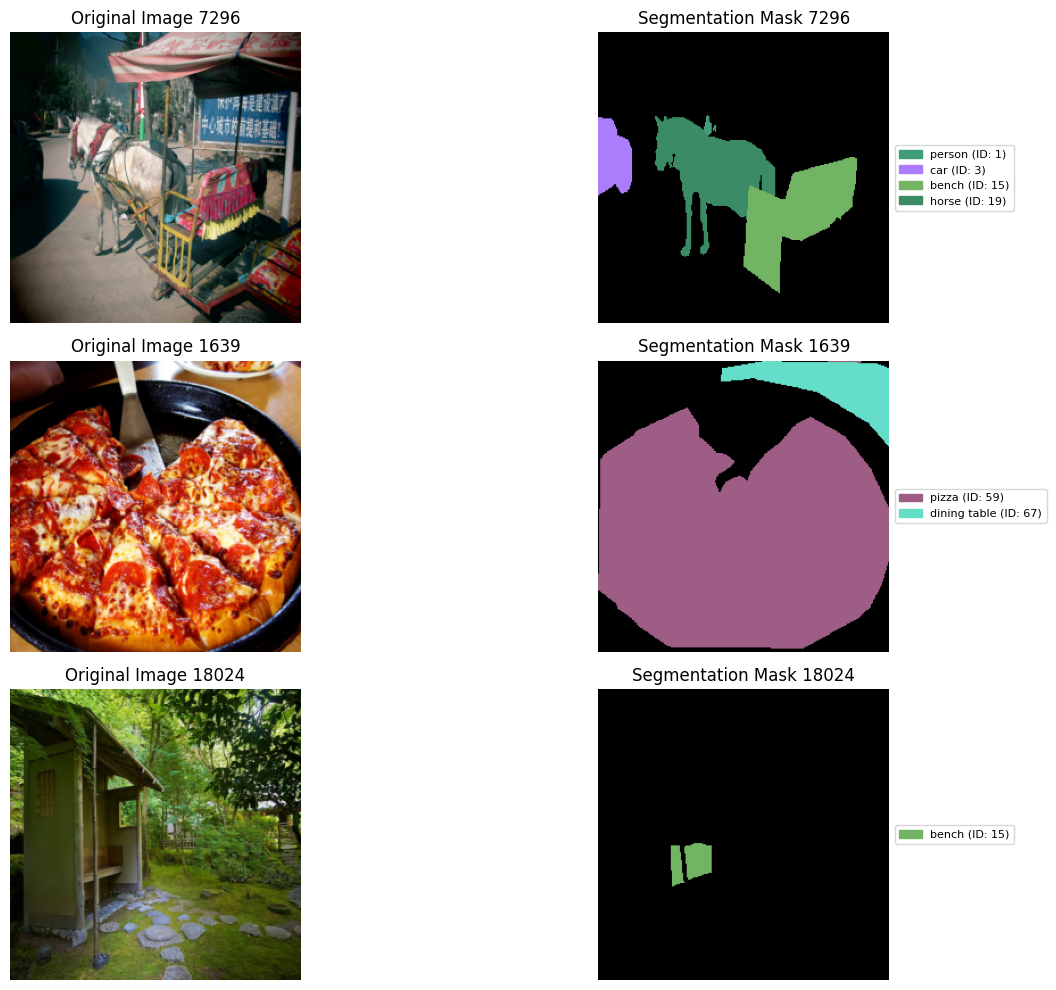

In [34]:
root_dir = 'val2014'  # Path to images
ann_file = 'annotations/instances_val2014.json'  # Path to annotations

# Create and initialize the dataset
dataset = COCOSegmentationDataset(
    root_dir=root_dir,
    annFile=ann_file,
    transform=transforms.ToTensor(),
    size=(256, 256)  # Resize images to this size
)

# Visualize masks and images
visualize_coco_masks(dataset, num_samples=3)

#### Define the U-Net model

In [46]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=91):  # COCO has 90 classes + background
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (Expansive Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)  # 512 + 512 = 1024 (skip connection)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)  # 256 + 256 = 512 (skip connection)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)  # 128 + 128 = 256 (skip connection)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)  # 64 + 64 = 128 (skip connection)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        x = self.pool(enc1)

        enc2 = self.encoder2(x)
        x = self.pool(enc2)

        enc3 = self.encoder3(x)
        x = self.pool(enc3)

        enc4 = self.encoder4(x)
        x = self.pool(enc4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x = self.upconv4(x)
        # Ensure that enc4 and x have compatible sizes for concatenation
        if x.size() != enc4.size():
            x = F.interpolate(x, size=enc4.size()[2:])
        x = torch.cat([enc4, x], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        # Ensure that enc3 and x have compatible sizes for concatenation
        if x.size() != enc3.size():
            x = F.interpolate(x, size=enc3.size()[2:])
        x = torch.cat([enc3, x], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        # Ensure that enc2 and x have compatible sizes for concatenation
        if x.size() != enc2.size():
            x = F.interpolate(x, size=enc2.size()[2:])
        x = torch.cat([enc2, x], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        # Ensure that enc1 and x have compatible sizes for concatenation
        if x.size() != enc1.size():
            x = F.interpolate(x, size=enc1.size()[2:])
        x = torch.cat([enc1, x], dim=1)
        x = self.decoder1(x)

        # Output layer
        x = self.output(x)
        return x

#### Create datasets and dataloaders
def create_dataloaders(batch_size=8, train_fraction=0.1, val_fraction=0.1, seed=42):
    """
    Create dataloaders with optional subset selection to reduce memory usage.

    Args:
        batch_size (int): Batch size for training
        train_fraction (float): Fraction of training data to use (0.0-1.0)
        val_fraction (float): Fraction of validation data to use (0.0-1.0)
        seed (int): Random seed for reproducibility

    Returns:
        tuple: (train_loader, val_loader, num_classes)
    """
    # Set random seed for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)

    # Create full datasets
    train_dataset = COCOSegmentationDataset(
        root_dir='train2014',
        annFile='annotations/instances_train2014.json',
        transform=transform,
        size=(256, 256)
    )

    val_dataset = COCOSegmentationDataset(
        root_dir='val2014',
        annFile='annotations/instances_val2014.json',
        transform=transform,
        size=(256, 256)
    )

    # Calculate subset sizes
    train_size = int(len(train_dataset) * train_fraction)
    val_size = int(len(val_dataset) * val_fraction)

    print(f"Full training dataset size: {len(train_dataset)}")
    print(f"Using {train_size} samples ({train_fraction*100:.1f}%) for training")
    print(f"Full validation dataset size: {len(val_dataset)}")
    print(f"Using {val_size} samples ({val_fraction*100:.1f}%) for validation")

    # Create random indices for subset selection
    train_indices = random.sample(range(len(train_dataset)), train_size)
    val_indices = random.sample(range(len(val_dataset)), val_size)

    # Create subset datasets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Create dataloaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Reduced number of workers to save memory
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Reduced number of workers to save memory
        pin_memory=True if torch.cuda.is_available() else False
    )

    return train_loader, val_loader, train_dataset.num_classes, train_dataset.categories, val_dataset.num_classes, val_dataset.categories

#### Define training function

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001,
                grad_accumulation_steps=4, save_dir='checkpoints'):
    """
    Train the model with optional gradient accumulation to reduce memory usage.

    Args:
        model: The UNet model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        grad_accumulation_steps: Number of steps to accumulate gradients (reduces memory usage)
        save_dir: Directory to save model checkpoints
    """
    # print("Create directory for saving models if it doesn't exist")
    os.makedirs(save_dir, exist_ok=True)

    # print("Define loss function and optimizer")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # print("Learning rate scheduler")
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # print("Training loop")
    train_losses = []
    val_losses = []
    val_ious = []

    for epoch in range(num_epochs):
        # print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        optimizer.zero_grad()  # Zero gradients at the beginning of epoch

        for batch_idx, (images, masks) in enumerate(train_loader):
            # print(f"Starting batch {batch_idx}/{len(train_loader)}")
            images = images.to(device)
            masks = masks.to(device)

            # print("Forward pass")
            outputs = model(images)
            loss = criterion(outputs, masks) / grad_accumulation_steps  # Normalize loss

            # print("Backward pass")
            loss.backward()

            # print("Gradient accumulation - only update weights every grad_accumulation_steps")
            if (batch_idx + 1) % grad_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item() * grad_accumulation_steps  # Scale back for reporting

            # Print progress and free memory
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item() * grad_accumulation_steps:.4f}")
                # Explicitly clear cache if using GPU
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        # print("Calculate average loss for the epoch")
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # Validation with memory-efficient implementation
        model.eval()
        val_loss = 0
        total_iou = 0
        num_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate IoU
                preds = torch.argmax(outputs, dim=1)
                iou = calculate_iou(preds, masks)
                total_iou += iou * images.size(0)
                num_samples += images.size(0)

                # Clear memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Calculate average IoU
        avg_iou = total_iou / num_samples
        val_ious.append(avg_iou)

        # Update learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {avg_iou:.4f}")

        # Save the model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'val_loss': val_loss,
            'val_iou': avg_iou
        }, os.path.join(save_dir, f'unet_epoch_{epoch+1}.pth'))

    return train_losses, val_losses, val_ious

#### Helper function to calculate IoU

In [8]:
def calculate_iou(pred, target):
    """
    Calculate Intersection over Union between prediction and target
    """
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # add small epsilon to avoid division by zero
    return iou.mean().item()

#### Function to visualize predictions

In [48]:
def visualize_predictions(model, val_loader: DataLoader, num_classes, classes, num_samples=5, save_path='segmentation_results.png'):
    model.eval()
    colors = np.random.RandomState(42).randint(50, 255, size=(num_classes, 3))
    colors[0] = [0, 0, 0]
    indices = random.sample(range(len(val_loader)), min(num_samples, len(val_loader)))
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))

    if num_samples == 1:
        axs = [axs]

    sample_count = 0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(val_loader):
            if sample_count >= num_samples:
                break

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Process one image at a time to save memory
            for i in range(min(len(images), num_samples - sample_count)):
                # Convert tensors to numpy arrays for visualization
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

                true_mask = masks[i].cpu().numpy()
                pred_mask = preds[i].cpu().numpy()

                colored_true_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)
                for class_idx in range(1, num_classes):  # Skip background
                    if class_idx in np.unique(true_mask):
                        colored_true_mask[true_mask == class_idx] = colors[class_idx]

                colored_pred_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
                for class_idx in range(1, num_classes):  # Skip background
                    if class_idx in np.unique(pred_mask):
                        colored_pred_mask[pred_mask == class_idx] = colors[class_idx]

                # Display results
                axs[sample_count, 0].imshow(img)
                axs[sample_count, 0].set_title('Input Image')
                axs[sample_count, 0].axis('off')

                axs[sample_count, 1].imshow(colored_true_mask)
                axs[sample_count, 1].set_title('Ground Truth')
                axs[sample_count, 1].axis('off')

                # Add legend for this specific image
                classes_in_true_image = np.unique(true_mask)
                classes_in_true_image = classes_in_true_image[classes_in_true_image > 0]  # Remove background

                if len(classes_in_true_image) > 0:
                    legend_patches = []
                    for class_idx in classes_in_true_image:
                        if class_idx in classes:
                            class_name = classes[class_idx]
                            patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                                   label=f"{class_name} (ID: {class_idx})")
                            legend_patches.append(patch)

                    if legend_patches:
                        axs[sample_count][1].legend(handles=legend_patches, loc='center left',
                                         bbox_to_anchor=(1, 0.5), fontsize=8)

                axs[sample_count, 2].imshow(colored_pred_mask)
                axs[sample_count, 2].set_title('Prediction')
                axs[sample_count, 2].axis('off')

                # Add legend for this specific image
                classes_in_pred_image = np.unique(pred_mask)
                classes_in_pred_image = classes_in_pred_image[classes_in_pred_image > 0]  # Remove background

                if len(classes_in_pred_image) > 0:
                    legend_patches = []
                    for class_idx in classes_in_pred_image:
                        if class_idx in classes:
                            class_name = classes[class_idx]
                            patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                                   label=f"{class_name} (ID: {class_idx})")
                            legend_patches.append(patch)
                    if legend_patches:
                        axs[sample_count][2].legend(handles=legend_patches, loc='center left',
                                                    bbox_to_anchor=(1, 0.5), fontsize=8)

                sample_count += 1
                if sample_count >= num_samples:
                    break

            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    plt.tight_layout()
    plt.show(fig)
    plt.savefig(save_path)
    print(f"Visualization saved to {save_path}")


#### Create dataloaders

In [49]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Create dataloaders with specified fractions
train_loader, val_loader, num_classes, train_classes, num_vel_classes, val_classes = create_dataloaders(
    batch_size=16,
    train_fraction=0.1,
    val_fraction=0.1
)
print(f"Number of classes: {num_classes}")

loading annotations into memory...
Done (t=12.81s)
creating index...
index created!
loading annotations into memory...
Done (t=3.85s)
creating index...
index created!
Full training dataset size: 82783
Using 8278 samples (10.0%) for training
Full validation dataset size: 40504
Using 4050 samples (10.0%) for validation
Number of classes: 91


In [50]:
# Initialize model
model = UNet(in_channels=3, out_channels=num_classes).to(device)

In [ ]:
# Train model
train_losses, val_losses, val_ious = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=20,
    learning_rate=0.001,
    grad_accumulation_steps=1  # Accumulate gradients over 4 steps
)

Epoch 1/20, Batch 0/518, Loss: 3.2916
Epoch 1/20, Batch 20/518, Loss: 2.6082
Epoch 1/20, Batch 40/518, Loss: 2.1411
Epoch 1/20, Batch 60/518, Loss: 1.7559
Epoch 1/20, Batch 80/518, Loss: 1.2580
Epoch 1/20, Batch 100/518, Loss: 1.2454
Epoch 1/20, Batch 120/518, Loss: 1.5131
Epoch 1/20, Batch 140/518, Loss: 1.4798
Epoch 1/20, Batch 160/518, Loss: 1.3739
Epoch 1/20, Batch 180/518, Loss: 1.2567
Epoch 1/20, Batch 200/518, Loss: 1.3773
Epoch 1/20, Batch 220/518, Loss: 1.2570
Epoch 1/20, Batch 240/518, Loss: 1.2418
Epoch 1/20, Batch 260/518, Loss: 1.0611
Epoch 1/20, Batch 280/518, Loss: 1.1829
Epoch 1/20, Batch 300/518, Loss: 1.6524
Epoch 1/20, Batch 320/518, Loss: 1.6866
Epoch 1/20, Batch 340/518, Loss: 1.4192
Epoch 1/20, Batch 360/518, Loss: 1.5622
Epoch 1/20, Batch 380/518, Loss: 1.1269
Epoch 1/20, Batch 400/518, Loss: 1.4698
Epoch 1/20, Batch 420/518, Loss: 1.4982
Epoch 1/20, Batch 440/518, Loss: 1.3332
Epoch 1/20, Batch 460/518, Loss: 1.1345
Epoch 1/20, Batch 480/518, Loss: 1.3045
Epoch 

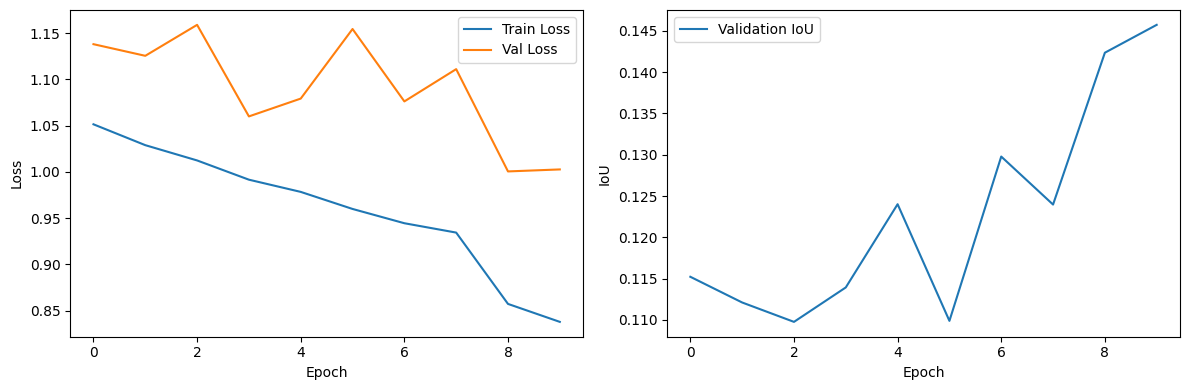

In [43]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

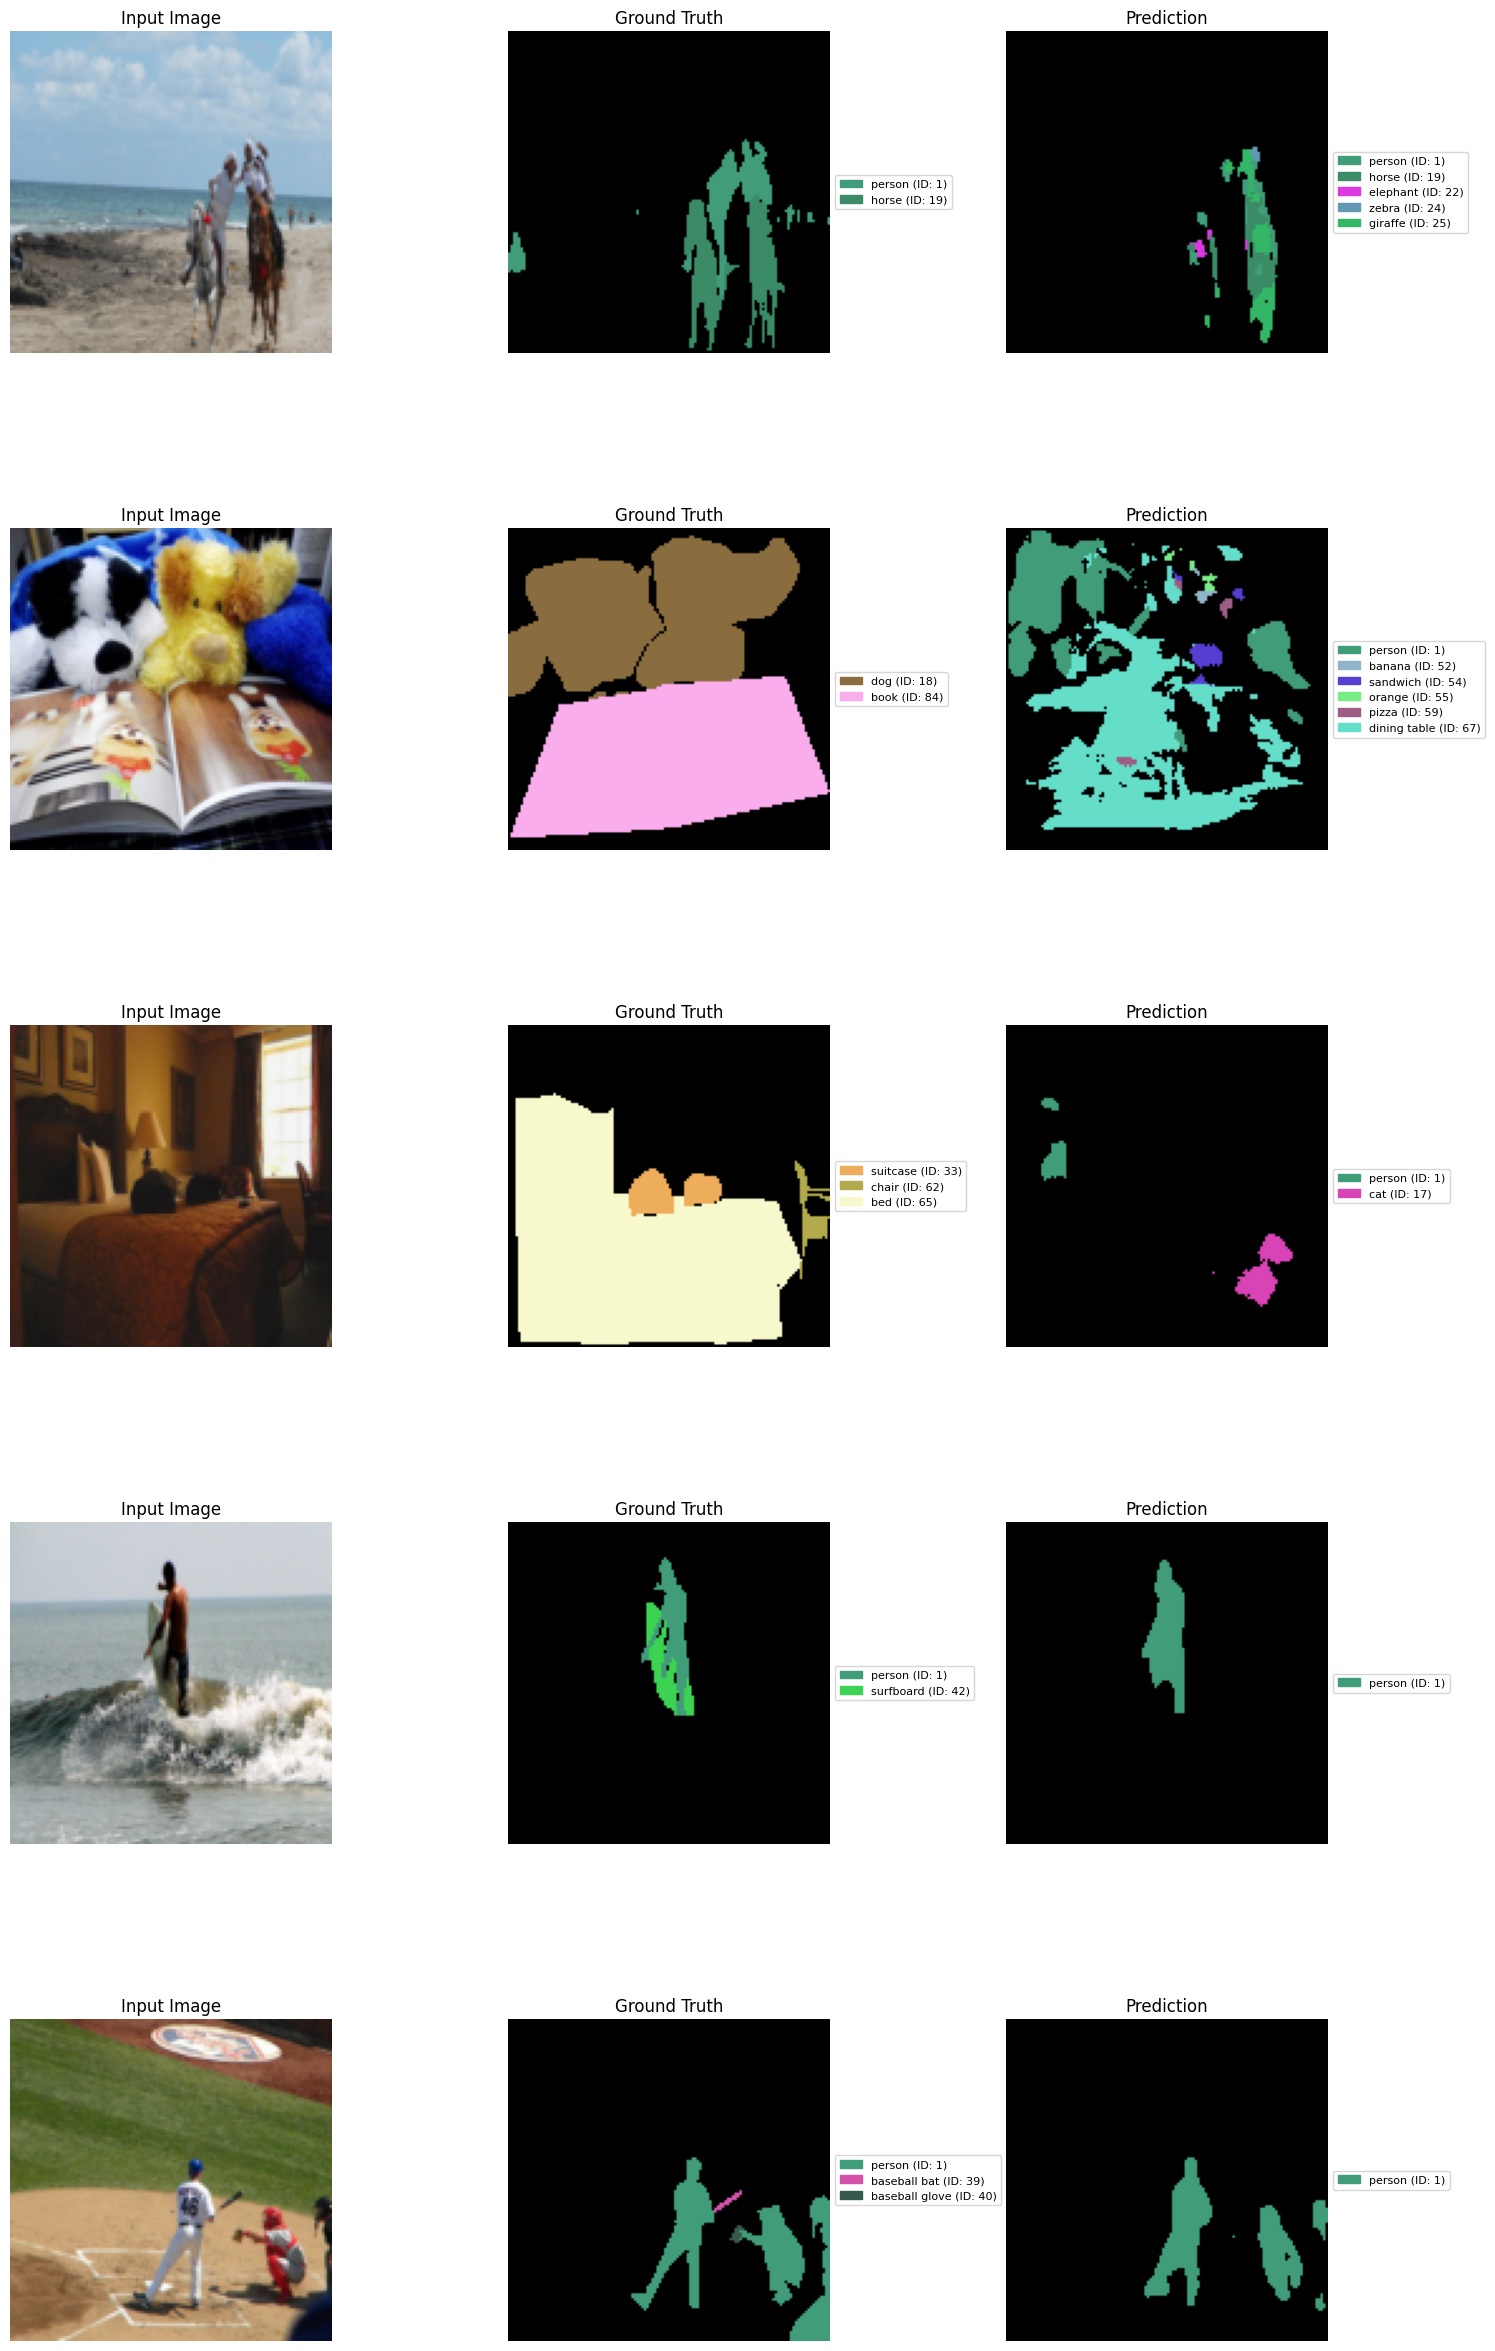

Visualization saved to segmentation_results.png


<Figure size 640x480 with 0 Axes>

In [45]:
def visualize_predictions(model, val_loader: DataLoader, num_classes, classes, num_samples=5, save_path='segmentation_results.png'):
    model.eval()
    colors = np.random.RandomState(42).randint(50, 255, size=(num_classes, 3))
    colors[0] = [0, 0, 0]
    indices = random.sample(range(len(val_loader)), min(num_samples, len(val_loader)))
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))

    if num_samples == 1:
        axs = [axs]

    sample_count = 0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(val_loader):
            if sample_count >= num_samples:
                break

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Process one image at a time to save memory
            for i in range(min(len(images), num_samples - sample_count)):
                # Convert tensors to numpy arrays for visualization
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

                true_mask = masks[i].cpu().numpy()
                pred_mask = preds[i].cpu().numpy()

                colored_true_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)
                for class_idx in range(1, num_classes):  # Skip background
                    if class_idx in np.unique(true_mask):
                        colored_true_mask[true_mask == class_idx] = colors[class_idx]

                colored_pred_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
                for class_idx in range(1, num_classes):  # Skip background
                    if class_idx in np.unique(pred_mask):
                        colored_pred_mask[pred_mask == class_idx] = colors[class_idx]

                # Display results
                axs[sample_count, 0].imshow(img)
                axs[sample_count, 0].set_title('Input Image')
                axs[sample_count, 0].axis('off')

                axs[sample_count, 1].imshow(colored_true_mask)
                axs[sample_count, 1].set_title('Ground Truth')
                axs[sample_count, 1].axis('off')

                # Add legend for this specific image
                classes_in_true_image = np.unique(true_mask)
                classes_in_true_image = classes_in_true_image[classes_in_true_image > 0]  # Remove background

                if len(classes_in_true_image) > 0:
                    legend_patches = []
                    for class_idx in classes_in_true_image:
                        if class_idx in classes:
                            class_name = classes[class_idx]
                            patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                                   label=f"{class_name} (ID: {class_idx})")
                            legend_patches.append(patch)

                    if legend_patches:
                        axs[sample_count][1].legend(handles=legend_patches, loc='center left',
                                                    bbox_to_anchor=(1, 0.5), fontsize=8)

                axs[sample_count, 2].imshow(colored_pred_mask)
                axs[sample_count, 2].set_title('Prediction')
                axs[sample_count, 2].axis('off')

                # Add legend for this specific image
                classes_in_pred_image = np.unique(pred_mask)
                classes_in_pred_image = classes_in_pred_image[classes_in_pred_image > 0]  # Remove background

                if len(classes_in_pred_image) > 0:
                    legend_patches = []
                    for class_idx in classes_in_pred_image:
                        if class_idx in classes:
                            class_name = classes[class_idx]
                            patch = mpatches.Patch(color=colors[class_idx]/255.0,
                                                   label=f"{class_name} (ID: {class_idx})")
                            legend_patches.append(patch)
                    if legend_patches:
                        axs[sample_count][2].legend(handles=legend_patches, loc='center left',
                                                    bbox_to_anchor=(1, 0.5), fontsize=8)

                sample_count += 1
                if sample_count >= num_samples:
                    break

            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    plt.tight_layout()
    plt.show(fig)
    plt.savefig(save_path)
    print(f"Visualization saved to {save_path}")


# Visualize some predictions
visualize_predictions(model, val_loader, num_vel_classes, val_classes)

## Conclusion

The U-Net model demonstrates good efficiency in detecting persons within simple images. However, its performance significantly declines when tasked with detecting a broader range of object types. This indicates that while U-Net is effective in certain scenarios, its generalization capability remains limited in more complex object detection tasks.

To enhance the model’s performance and robustness, future work could include:

- Increasing the input image resolution to capture finer details.
- Extending the number of training epochs for better convergence.
- Expanding the batch size or overall dataset to improve model generalization and reduce overfitting.

